# Analisis exploratorio

In [1]:
%load_ext autoreload
%autoreload 2
BASE_PATH='..'

In [2]:
import sys
sys.path.append(f'{BASE_PATH}/lib')

from pytorch_common.util import LoggerBuilder

import numpy as np
import pandas as pd

from data.missing import MissingsManager
import data as dt
import data.plot as pl
import util as ut

import seaborn as sns
import matplotlib.pyplot as plt

2023-11-07 18:46:37.691557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 18:46:38.303915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-07 18:46:38.942173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 18:46:39.034779: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

<Figure size 640x480 with 0 Axes>

In [3]:
LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

## Carga de dataset

1. Importamos los archivos de peliculas y ratings preprocesados previamente en mongodb:

In [7]:
DATASETS_PATH   = f'{BASE_PATH}/datasets'

movies          = pd.read_json(f'{DATASETS_PATH}/movies_v4.json')
interactions    = pd.read_json(f'{DATASETS_PATH}/ratings_tags_v1.json')

In [8]:
interactions = interactions.drop('_id', axis=1)


movies['id']  = movies['_id']
movies  = movies.drop(['_id', 'tmdb_id'], axis=1)
movies['release'] = pd.to_datetime(movies['release'], format='%Y-%m-%d')

In [9]:
interactions.dtypes

rating              float64
timestamp    datetime64[ns]
user_id               int64
movie_id              int64
tags                 object
dtype: object

In [10]:
movies.dtypes

imdb_id                       int64
title                        object
genres                       object
for_adults                   object
budget                        int64
original_language            object
overview                     object
poster                       object
release              datetime64[ns]
popularity                  float64
vote_mean                   float64
vote_count                  float64
tags                         object
id                            int64
dtype: object

In [11]:
interactions.head()

rating           timestamp  user_id  movie_id  \
0     4.5 2015-07-27 21:07:28   100001       260   
1     4.5 2016-01-16 12:58:26   100016    111659   
2     2.0 2016-01-16 13:01:35   100016    112290   
3     5.0 2015-01-25 20:55:28   100016    114180   
4     4.5 2017-01-02 08:42:53   100016    117438   

                                                tags  
0  [adventure, classic, classic sci-fi, epic, joh...  
1         [fairy tale, good vs evil, visual effects]  
2               [bad jokes, boring, horrible acting]  
3       [amnesia, good acting, plot holes, survival]  
4                         [beautiful, studio ghibli]

In [12]:
movies.head()

imdb_id                         title  \
0   114709                    Toy Story    
1   113497                      Jumanji    
2   114319                      Sabrina    
3   114885            Waiting to Exhale    
4   113041  Father of the Bride Part II    

                                              genres for_adults    budget  \
0  [Adventure, Animation, Children, Comedy, Fantasy]      False  30000000   
1                     [Adventure, Children, Fantasy]      False  65000000   
2                                  [Comedy, Romance]      False  58000000   
3                           [Comedy, Drama, Romance]      False  16000000   
4                                           [Comedy]      False         0   

  original_language                                           overview  \
0                en  Led by Woody, Andy's toys live happily in his ...   
1                en  When siblings Judy and Peter discover an encha...   
2                en  An ugly duckling having undergone a remarkable...   
3                en  Cheated on, mistreated and stepped on, the wom...   
4                en  Just when George Banks has recovered from his ...   

                             poster    release  popularity  vote_mean  \
0  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg 1995-10-30   21.946943        7.7   
1  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg 1995-12-15   17.015539        6.9   
2  /jQh15y5YB7bWz1NtffNZmRw0s9D.jpg 1995-12-15    6.677277        6.2   
3  /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg 1995-12-22    3.859495        6.1   
4  /e64sOI48hQXyru7naBFyssKFxVd.jpg 1995-02-10    8.387519        5.7   

   vote_count                                               tags  id  
0      5415.0  [2009 reissue in stereoscopic 3-d, 3d, 55 movi...   1  
1      2413.0  [adaptation of book, adapted from:book, advent...   2  
2       141.0  [as good maybe better than original, based on ...   7  
3        34.0  [based on novel or book, characters, chick fli...   4  
4       173.0  [aging, baby, clv, comedy, confidence, contrac...   5

## Valores faltantes

### Movies

Configuramos un instancia de **MissingsManager** con reglas que toman los ceros como valores faltantes para la variable budget, vote_mean y vote_count.

In [13]:
mm = MissingsManager() \
    .add_rule_fn('popularity', lambda v: v <= 0) \
    .add_rule_fn('budget', lambda v: v <= 0) \
    .add_rule_fn('vote_mean', lambda v: v <= 0) \
    .add_rule_fn('vote_count', lambda v: v <= 0)

movies.pipe(mm.report)

Column  Percent (%)  Count                    rule  \
0      budget     0.772227  27143     CustomMissingFnRule   
1      poster     0.000085      3  ColumnMissingValueRule   
2     release     0.000854     30  ColumnMissingValueRule   
3  popularity     0.000541     19     CustomMissingFnRule   
4   vote_mean     0.048024   1688     CustomMissingFnRule   
5  vote_count     0.045833   1611     CustomMissingFnRule   

                                             indexes  
0  [4, 8, 10, 11, 14, 15, 17, 18, 21, 25, 26, 27,...  
1                              [17450, 24442, 28570]  
2  [15236, 15316, 17450, 17676, 20298, 22988, 244...  
3  [5357, 15236, 17676, 17786, 18100, 18806, 2302...  
4  [100, 123, 126, 151, 363, 365, 378, 539, 545, ...  
5  [100, 123, 126, 151, 363, 365, 378, 545, 547, ...

Removemos las filas del dataset para aquellas columnas del reporte de valores faltantes que tengan una cantida de hasta 0.06 % de valores faltantes:

In [14]:
movies2 = movies.pipe(mm.remove_rows, max_missings=0.06)

2023-11-07 18:47:23,435 - INFO - Remove rows for columns <= 0.06 % of missings values.


In [15]:
movies2.pipe(mm.report)

Column  Percent (%)  Count                 rule  \
0  budget     0.762289  25494  CustomMissingFnRule   

                                             indexes  
0  [4, 8, 10, 11, 14, 15, 17, 18, 21, 25, 26, 27,...

De esta forma, borramos todas las filas con missing values en columnas con un porcentaje de missing <= 0.06, quedandonos solamente una columna con un porcentaje mayor de missing values. Esta columna no se puede utilizar en el entrenamiento, ya que tiene 70% de missing values. Por esta cuestion optamos por removerla del dataset.

In [16]:
movies3 = movies2.pipe(mm.remove_columns, max_percent=0.4)

2023-11-07 18:48:38,310 - INFO - Remove columns with missing >= 0.4 %


In [17]:
movies3.pipe(mm.report)

Column
0  Not found columns with missing values

Finalemente obtenemos un dataset sin missings.

In [18]:
movies3.head()

imdb_id                         title  \
0   114709                    Toy Story    
1   113497                      Jumanji    
2   114319                      Sabrina    
3   114885            Waiting to Exhale    
4   113041  Father of the Bride Part II    

                                              genres for_adults  \
0  [Adventure, Animation, Children, Comedy, Fantasy]      False   
1                     [Adventure, Children, Fantasy]      False   
2                                  [Comedy, Romance]      False   
3                           [Comedy, Drama, Romance]      False   
4                                           [Comedy]      False   

  original_language                                           overview  \
0                en  Led by Woody, Andy's toys live happily in his ...   
1                en  When siblings Judy and Peter discover an encha...   
2                en  An ugly duckling having undergone a remarkable...   
3                en  Cheated on, mistreated and stepped on, the wom...   
4                en  Just when George Banks has recovered from his ...   

                             poster    release  popularity  vote_mean  \
0  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg 1995-10-30   21.946943        7.7   
1  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg 1995-12-15   17.015539        6.9   
2  /jQh15y5YB7bWz1NtffNZmRw0s9D.jpg 1995-12-15    6.677277        6.2   
3  /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg 1995-12-22    3.859495        6.1   
4  /e64sOI48hQXyru7naBFyssKFxVd.jpg 1995-02-10    8.387519        5.7   

   vote_count                                               tags  id  
0      5415.0  [2009 reissue in stereoscopic 3-d, 3d, 55 movi...   1  
1      2413.0  [adaptation of book, adapted from:book, advent...   2  
2       141.0  [as good maybe better than original, based on ...   7  
3        34.0  [based on novel or book, characters, chick fli...   4  
4       173.0  [aging, baby, clv, comedy, confidence, contrac...   5

In [19]:
movie_missings_percent = 1 - (len(movies3) / len(movies))

print(f'El porcentaje filas con valores faltantes en la tabla movies es del {movie_missings_percent:.2f} %')

El porcentaje filas con valores faltantes en la tabla movies es del 0.05 %

### Interactions

In [20]:
mm = MissingsManager() \
    .add_rule_fn('tags', lambda v: len(v) == 0) \
    .add_rule_fn('rating', lambda v: v < 0.5)

interactions.pipe(mm.report)

Column
0  Not found columns with missing values

Renombramos la tabla ratings como interactions, ya que esta representa la acción que realiza un usuario al clasificar una pelicula. Ademas, se registra el momento del evento y por otro lado tenemos los tags que cargo el mismo usaurio a la pelicula pelicula clasificada. 

Para chequear faltantes agregarmos dos reglas extra:

- Si la columna tags no tiene valores (Cada valor es una colección), se toma con un valor faltante.
- Si tenemos ratings menores a 0.5, los tomamos con un valor faltante.

Finalmente, se peude aprecia que el reporte de missing values no muestra columnas con valores faltantes.

## ¿Con que número de peliculas y usuarios contamos?

**Peliculas:**

In [21]:
len(np.unique(movies3.id.values))

33444

**Usuarios que calificaron peliculas**: No es lo mismo que el total de usuarios. Esto son los usuarios quw al menos calificaron una pelicula.

In [22]:
len(np.unique(interactions.user_id.values))

13281

**Cantidad de peliculas calificadas por al menos un usuario:**

In [23]:
len(np.unique(interactions.movie_id.values))

22082

## Variables

A continacion analizamos cada variable en ambas tablas.

### Movies

A continaución analizamos cada variable de la tabla movies.

In [24]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35149 entries, 0 to 35148
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_id            35149 non-null  int64         
 1   title              35149 non-null  object        
 2   genres             35149 non-null  object        
 3   for_adults         35149 non-null  object        
 4   budget             35149 non-null  int64         
 5   original_language  35149 non-null  object        
 6   overview           35149 non-null  object        
 7   poster             35146 non-null  object        
 8   release            35119 non-null  datetime64[ns]
 9   popularity         35146 non-null  float64       
 10  vote_mean          35146 non-null  float64       
 11  vote_count         35146 non-null  float64       
 12  tags               35149 non-null  object        
 13  id                 35149 non-null  int64         
dtypes: dat

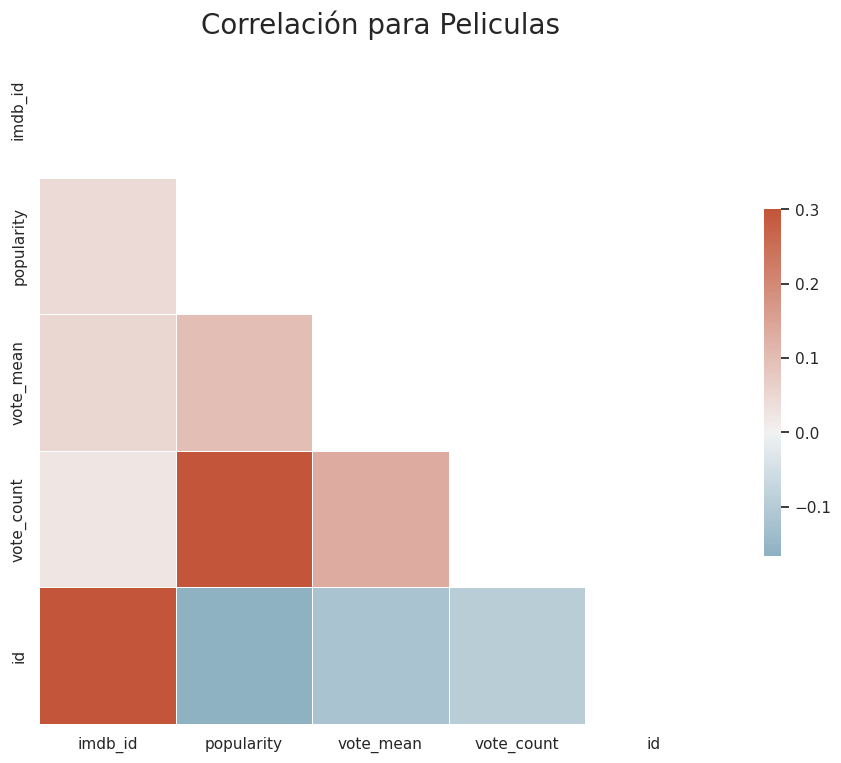

In [25]:
pl.correlations(
    movies3, 
    title='Correlación para Peliculas'
)

#### Popilarity

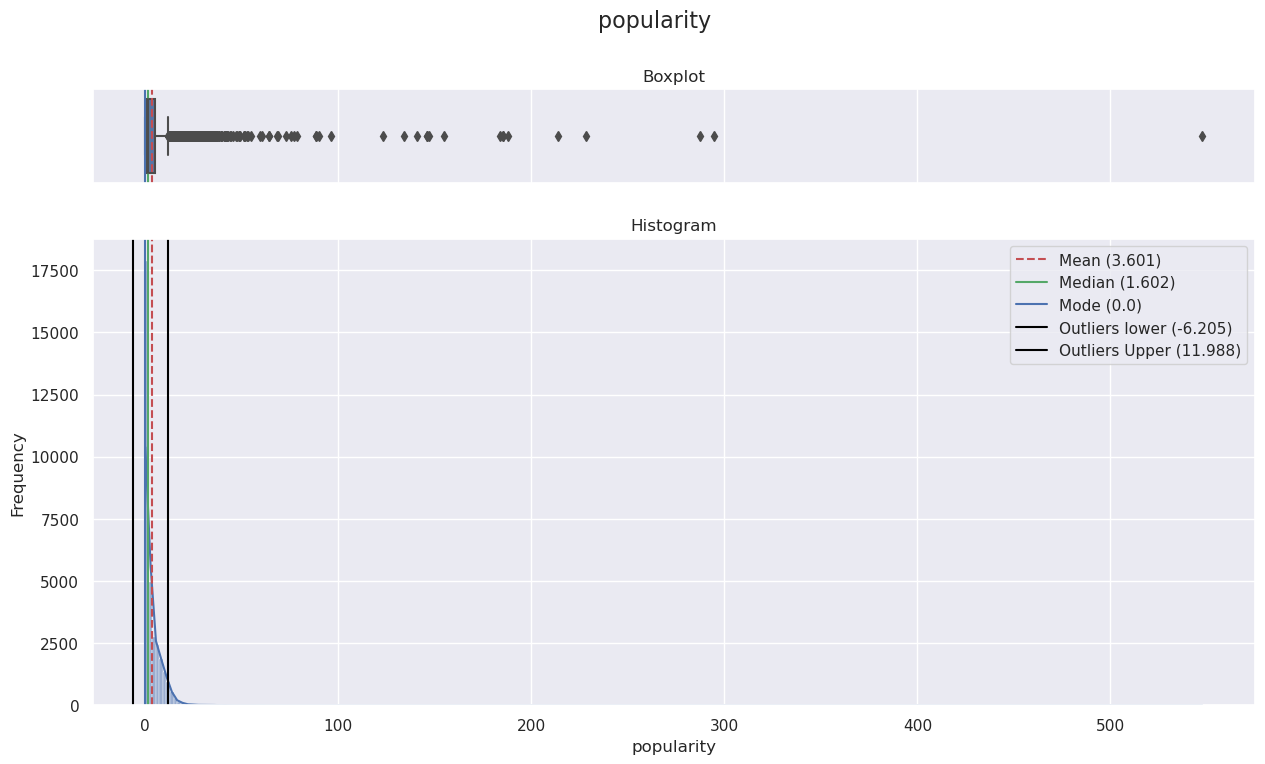

In [26]:
pl.l_size()
pl.describe_num_var(movies3, "popularity", bins=300)

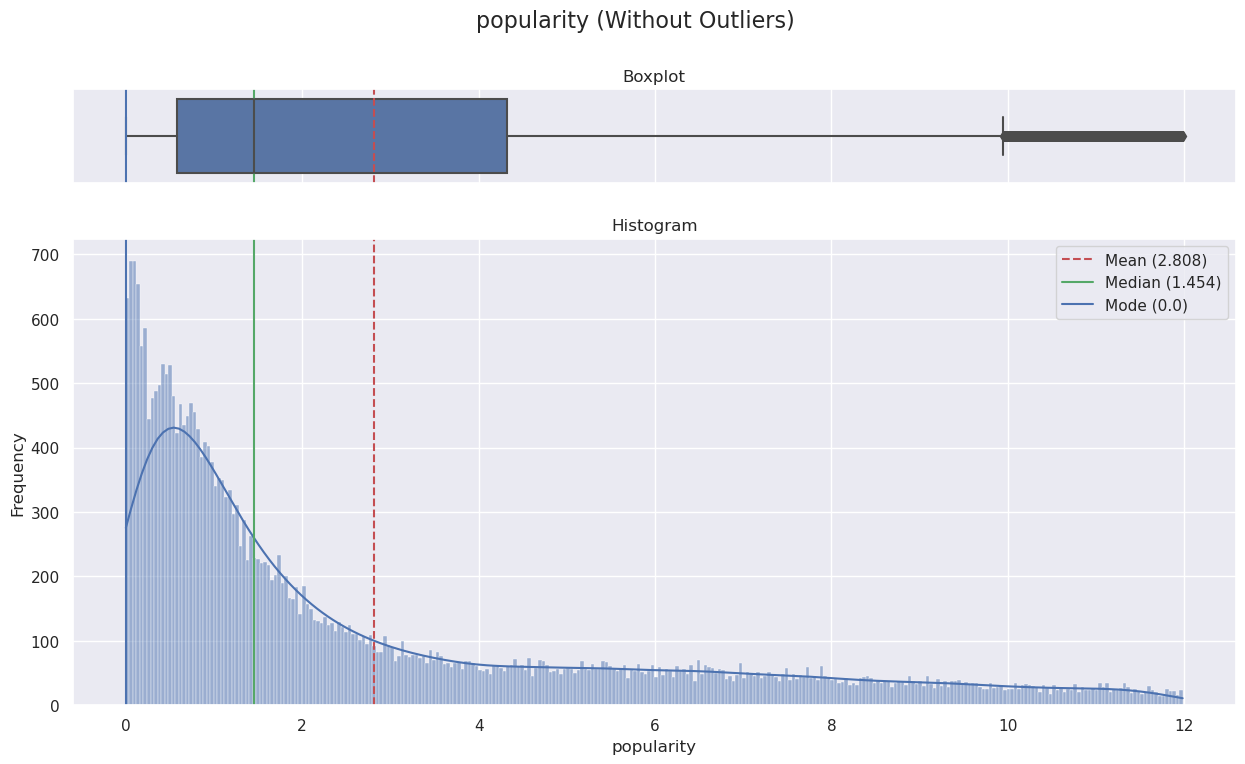

In [27]:
pl.describe_num_var(movies3, "popularity", bins=300, remove_outliers=True)

**Observaciones**

* La popularidad mantiene la relación de una ley de potencias, donde pocas peliculas son muy populares siendo en su mayoria valores atipicos, por encima de bigote superior o maximo y muchas peliculas tiene valores bajs de popularidad.
* Si quitams todos los valores > Q3+1.5*IQR y < Q1-1.5*IQR vemos con mas claridad una distribucion sesgadda a derecha y por ende la mediana y media a izquierda.
* La mode se encuetra en el cero. Esto nos dice que la mayoria de peliculas tiene popularidad cero.

### For Adults

¿La pelicula esta catalogada para mayores de edad? 

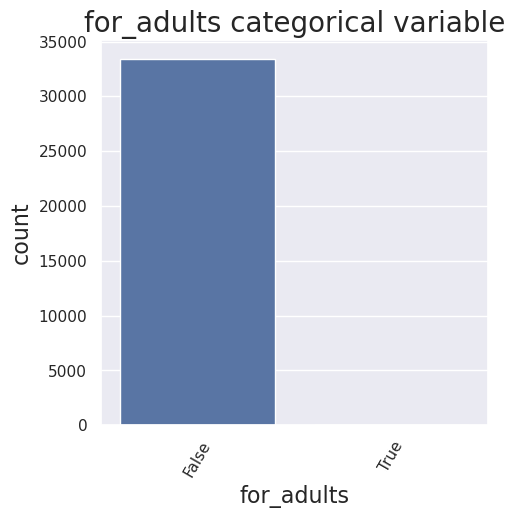

In [28]:
pl.s_size()
pl.describe_cat_var(movies3, "for_adults")

**Observaciones**

* Se aprecia que esta variable esta muy desbalanceada. 
* Ademas es inconsistente, ya que de 33.444 peliculas solo 6 son para adultos. Por esta cuestión esta columna no es apto para el entrenamiento y se decidio removerla.

### Release

Se refiere a la fecha de estreno de la pelicula.

In [29]:
movies3['release_year'] = movies3.release.dt.year

In [30]:
movies3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33444 entries, 0 to 35148
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_id            33444 non-null  int64         
 1   title              33444 non-null  object        
 2   genres             33444 non-null  object        
 3   for_adults         33444 non-null  object        
 4   original_language  33444 non-null  object        
 5   overview           33444 non-null  object        
 6   poster             33444 non-null  object        
 7   release            33444 non-null  datetime64[ns]
 8   popularity         33444 non-null  float64       
 9   vote_mean          33444 non-null  float64       
 10  vote_count         33444 non-null  float64       
 11  tags               33444 non-null  object        
 12  id                 33444 non-null  int64         
 13  release_year       33444 non-null  int64         
dtypes: dat

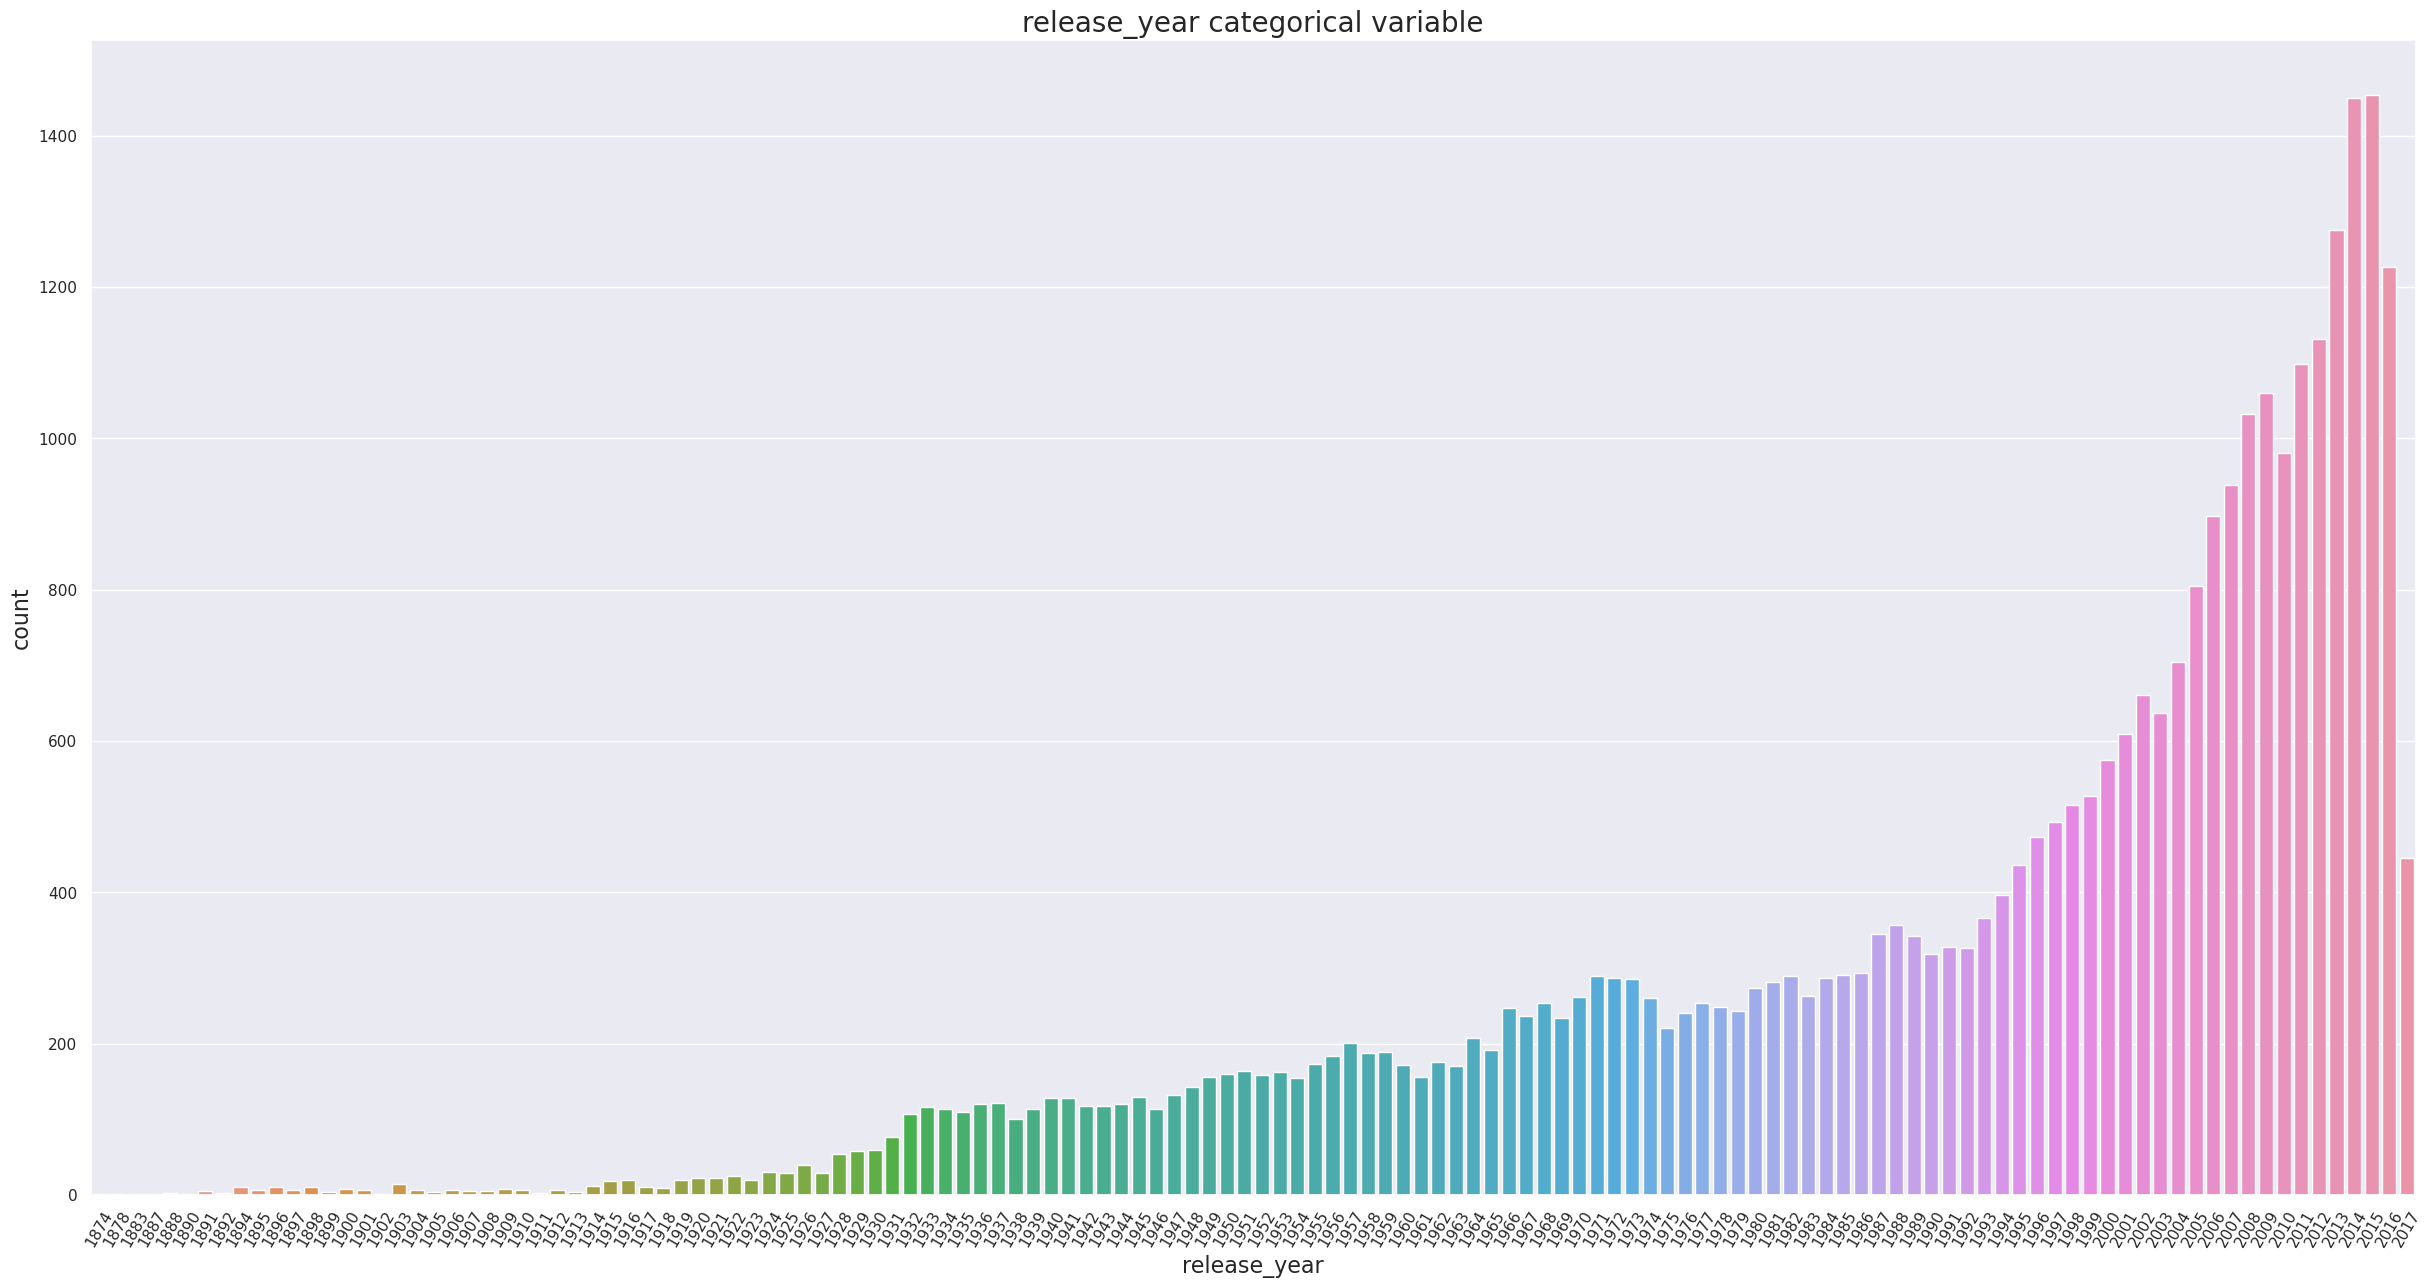

In [31]:
pl.xxl_size()
pl.describe_cat_var(movies3, 'release_year', order_column='release_year')

**Observaciones**

* Acalramos que hay una icinsitencia de datos. Hay años como 2005 donde el primero de enero tiene todos los estrenso de año y otros deonde los estrenos estan repartidos en varias fechas. Esto nos dice que es posible que en realidad este campo represente la cantidad de pelicula extrenada por año o bien que esa sea la cardinalidad real de los datos.
* Por otro lado en el grafico se aprecia que la cantidad de peliculas estrenada por año crese exponencialmente y 2017 baja lo cual seguramente es decido a que no se encuentra todo el año.
* A partor del 1994 se aprecia in el mayor crecimiento.

### Original Language

Se refiere al lenguage del audio original de la pelicula.

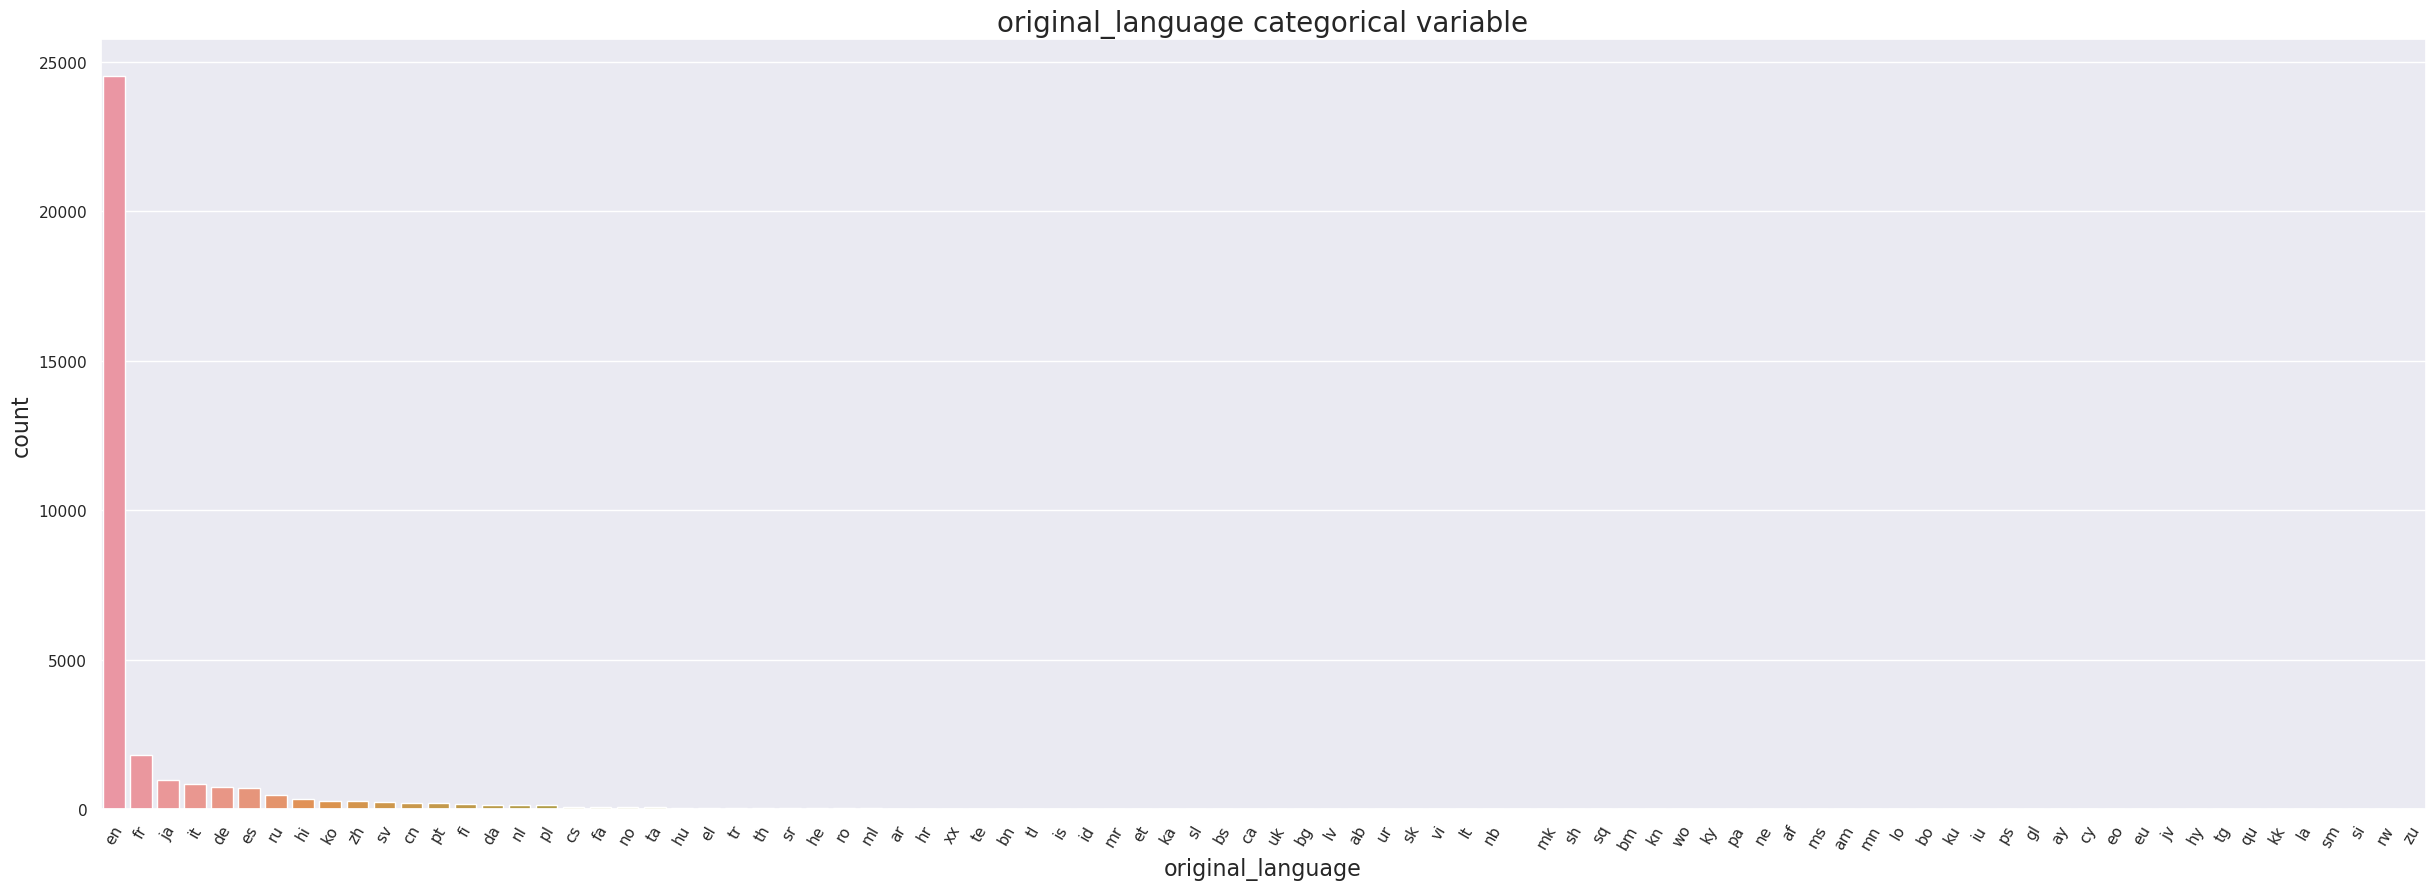

In [32]:
pl.xxl_flat_size()
pl.describe_cat_var(movies3, 'original_language')

**Observaciones**

* Es de esperar que el lenguage predominante sea el ingles.

!uitemos esta opcion y volvamos a graficas:

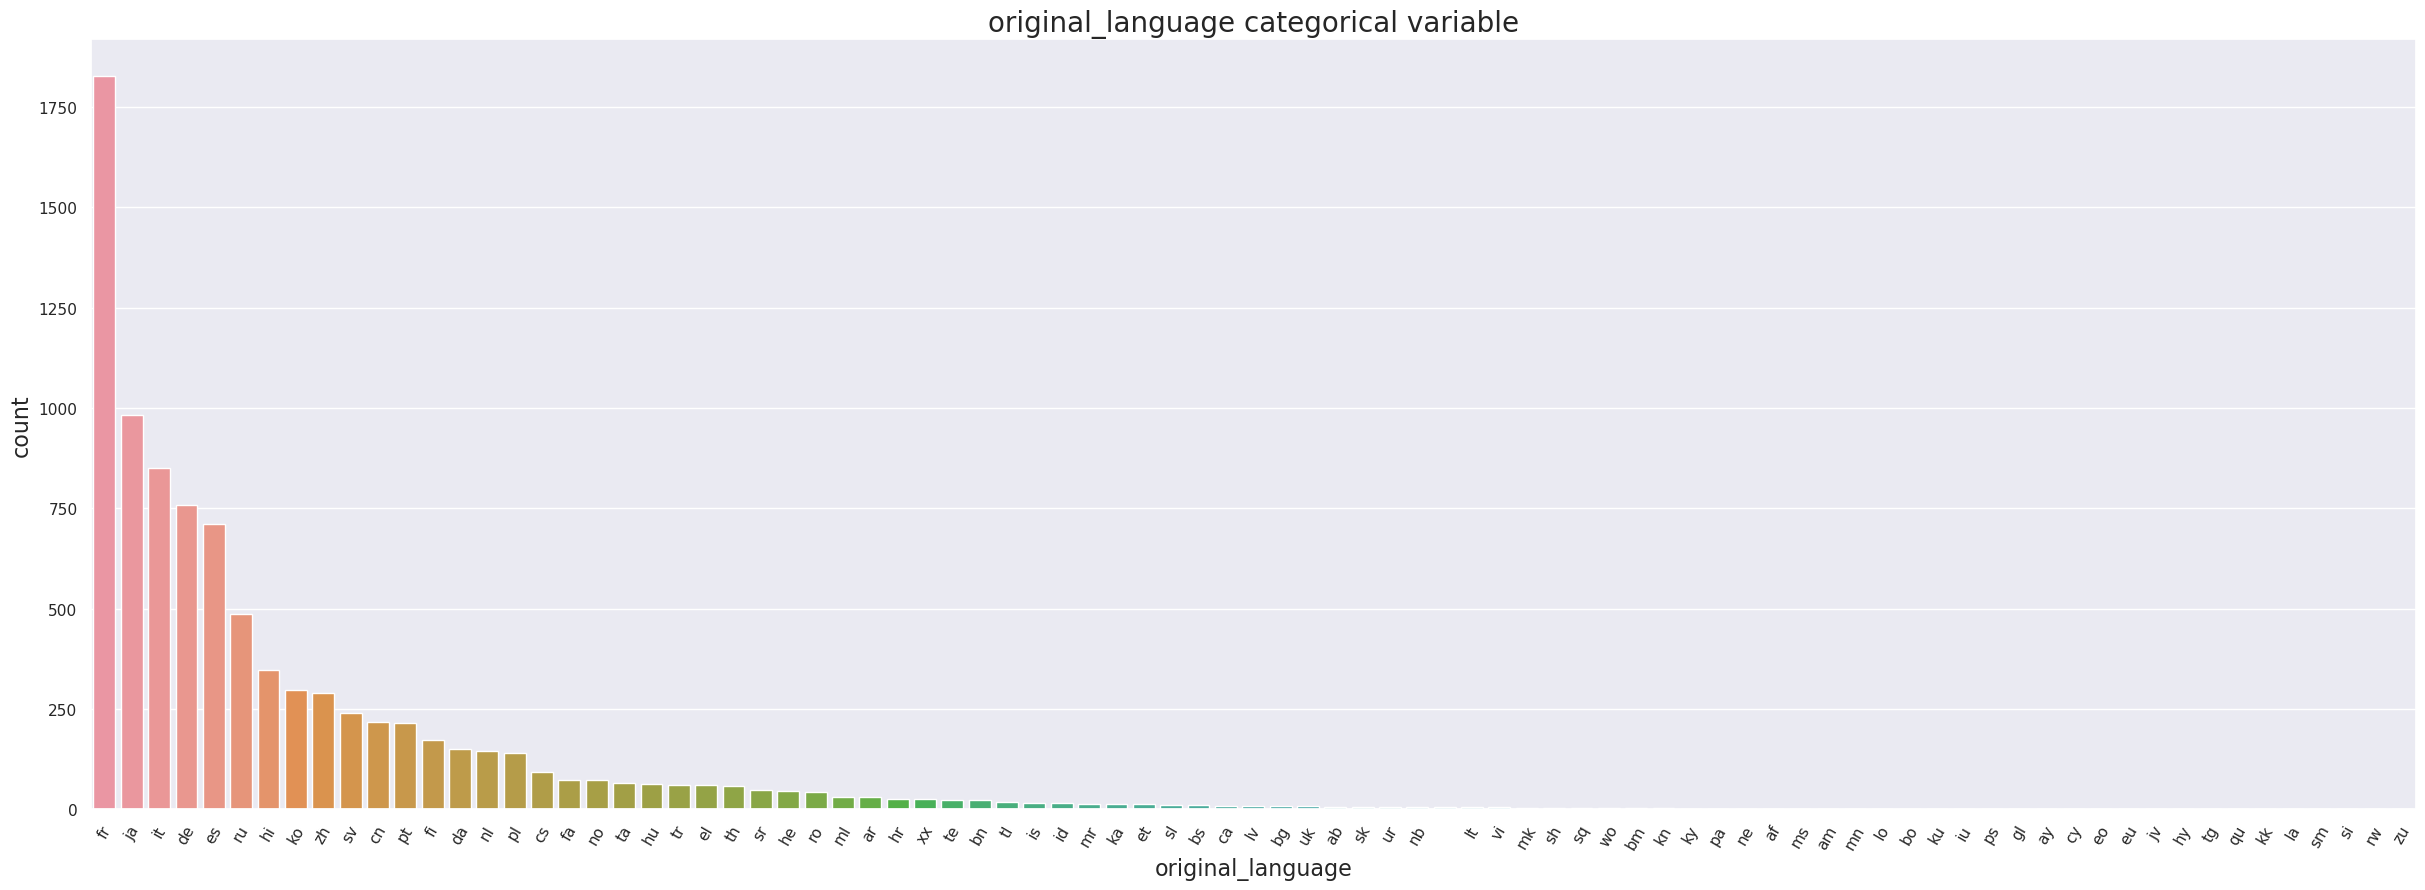

In [33]:
pl.xxl_flat_size()
pl.describe_cat_var(
    movies3[movies3['original_language'] != 'en'], 
    'original_language'
)

**Observaciones**

* Vemos que que los lenguajes frances, japones, italiana, aleman y español son los lenguages originales con mas mayor ferciencia. Eston indica indirectamente que son los paises con mas peso en el mundo sinematografico ademas de los paises de habla inglesa.

### Cantidad de votos

Representa la cantidad de votos o calificaciones que recibio la pelicula en el dataset en the movie database.

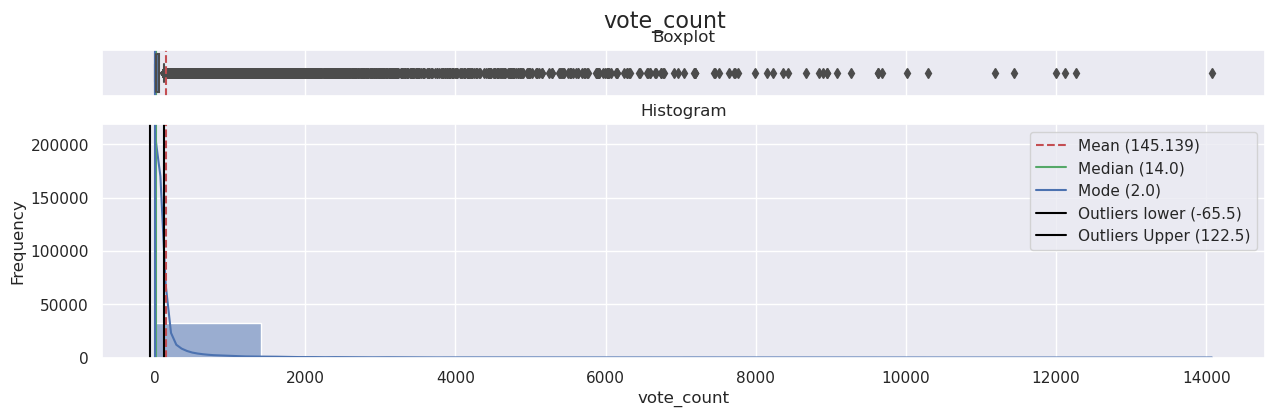

In [34]:
pl.l_flat_size()
pl.describe_num_var(movies3, "vote_count", bins=10)

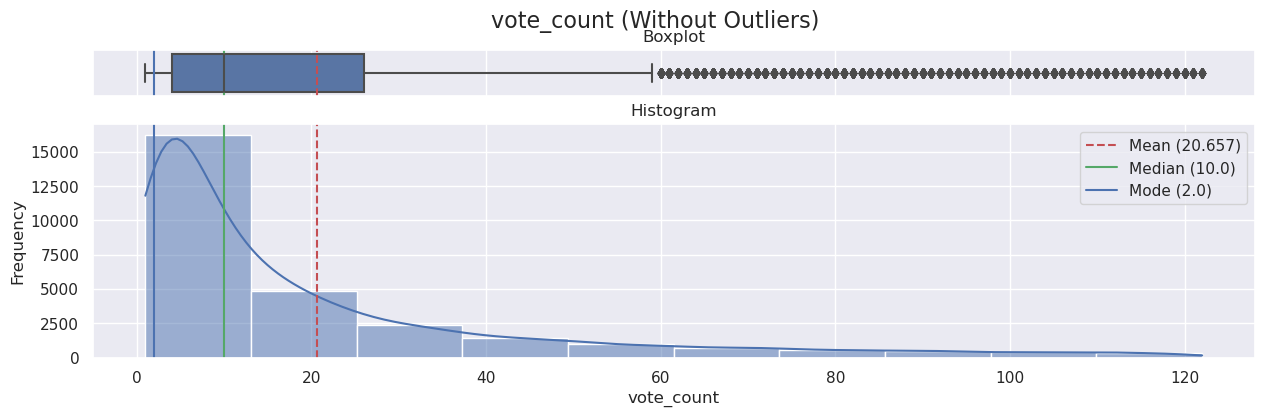

In [35]:
pl.describe_num_var(movies3, "vote_count", bins=10, remove_outliers=True)

### Tags

Esta columna tiene un conjunto sin repeticion de los tagas agragrados por todos los auaurios que calificaron una pelicula. Cada tag es una palabra o conunto de palabras. A continuacion se grafica una nube de palabras para visualiazr la freciencia relativa de las palabras que comonen los tagas:

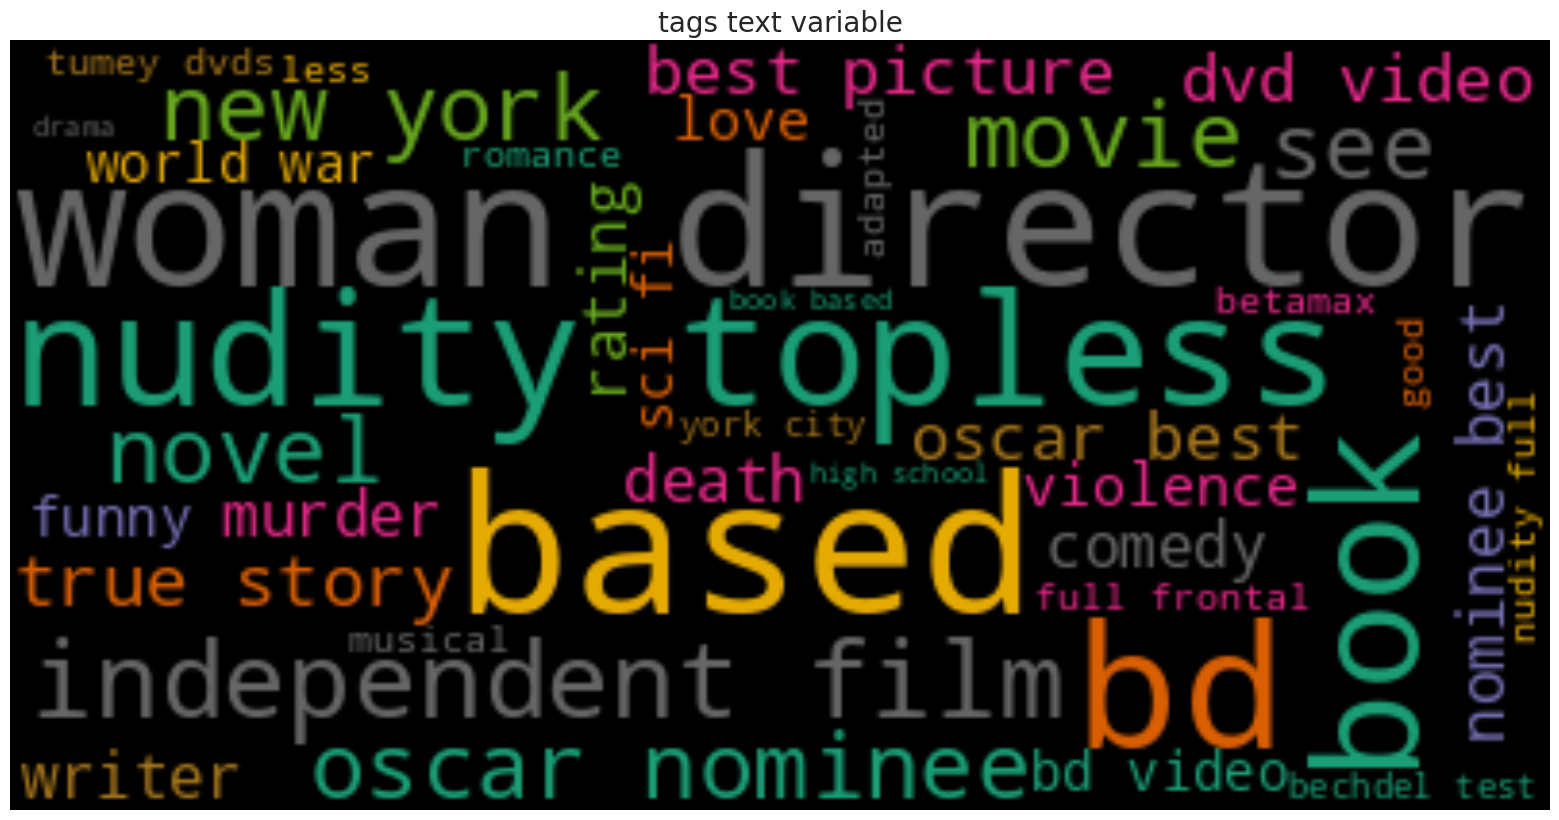

In [36]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'tags', flatten=True)

### Overview

La variable overview contiene la reseña o un resumen de la pelicula. Al igual qeu la variable tagas graficamos una nube de palabras para visualizar la freciencia relativa de las mismas:

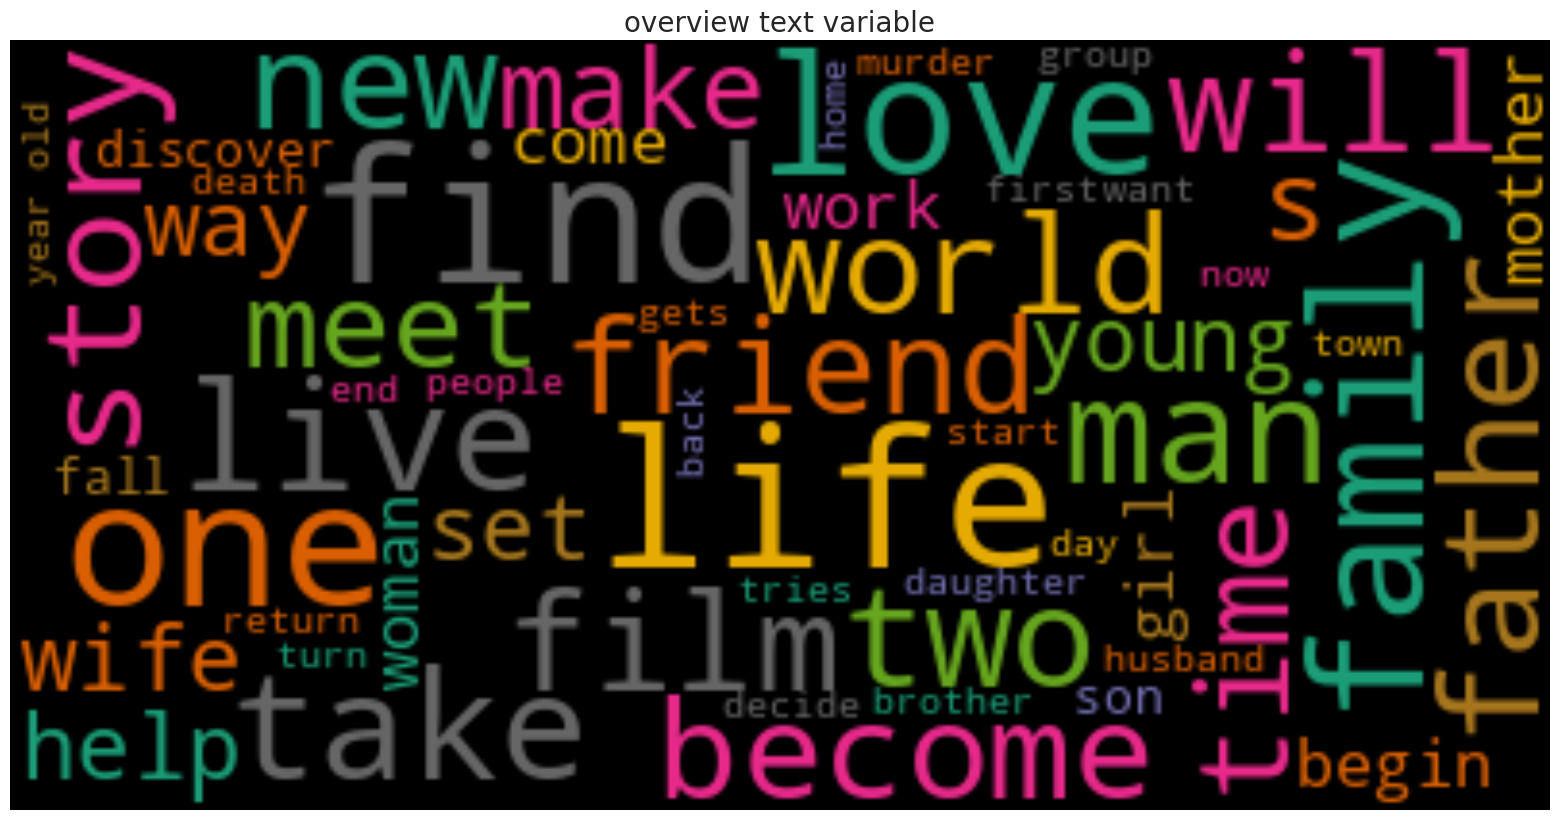

In [37]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'overview')

## Title

Esta varaible reprsenta el titulo de una pelicula. A continuacion nuevamente graficamos la frecuenia relativa de las palabar que componen todos los titulos del dataset:

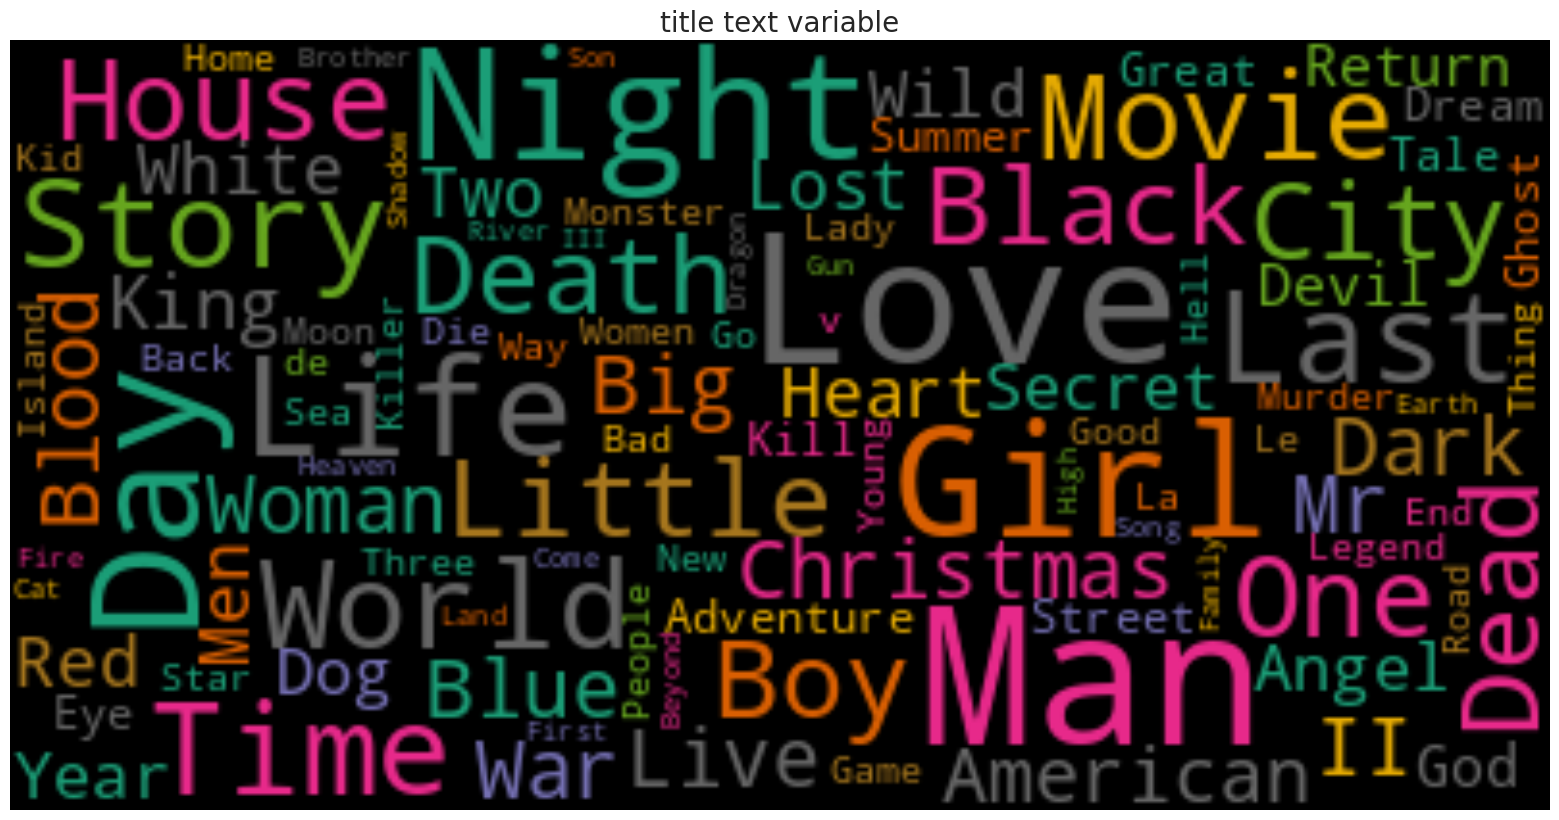

In [38]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'title')

## Interactions

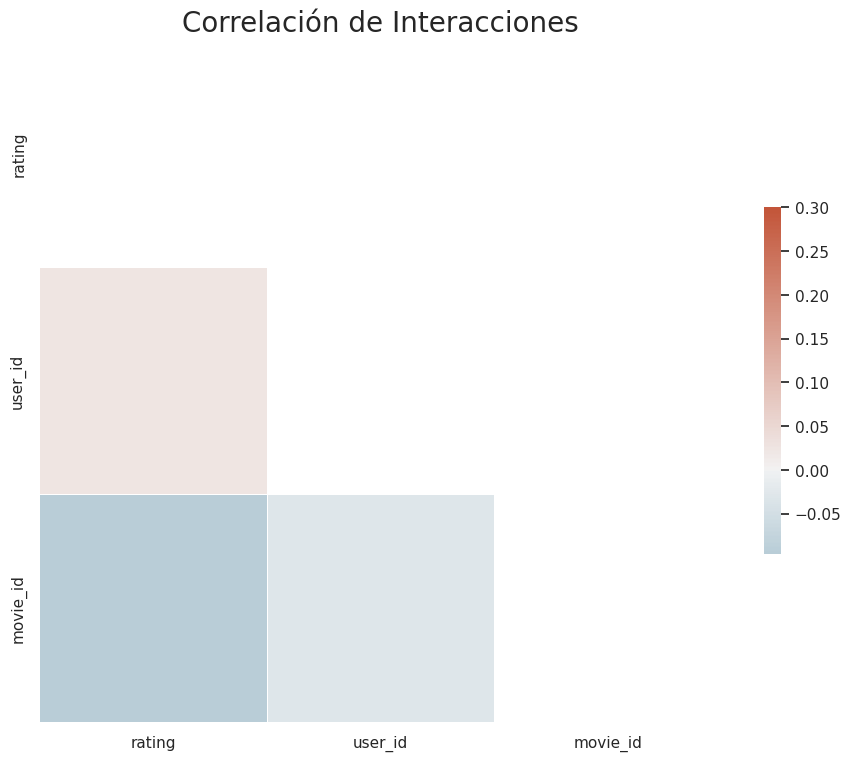

In [39]:
pl.correlations(
    interactions, 
    title='Correlación de Interacciones'
)

### Rating

In [40]:
dt.group_by(interactions, 'rating')

rating  count
7     4.0  49438
9     5.0  37157
6     3.5  34047
8     4.5  32330
5     3.0  25186
4     2.5  11889
3     2.0   8924
2     1.5   4225
1     1.0   3923
0     0.5   3606

Veamos la distribución de la calificaciones de la peliculas realizadas por los usaurio para todo el periodo del dataset:

In [41]:
years_range = (interactions['timestamp'].min().strftime("%Y-%m"), interactions['timestamp'].max().strftime("%Y-%m"))
years_range

('1997-09', '2019-11')

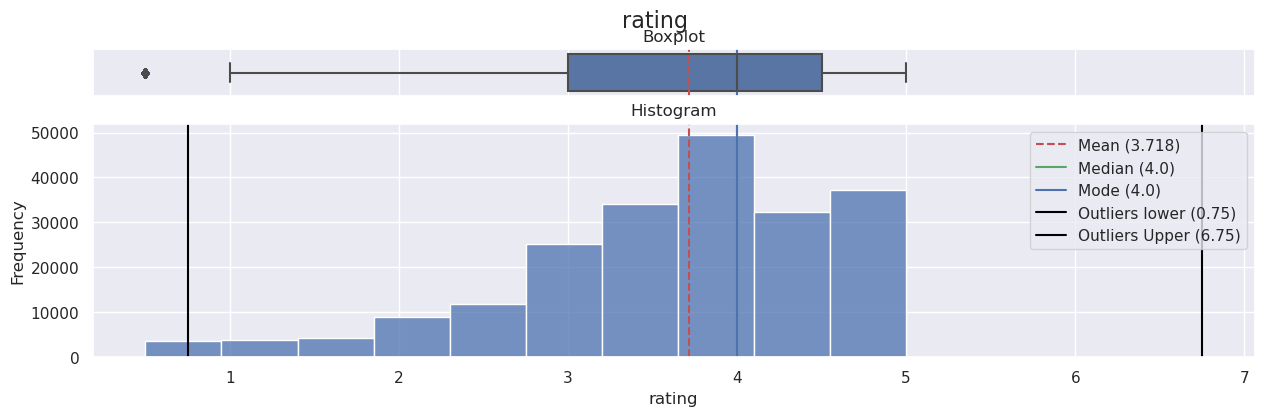

In [42]:
pl.l_flat_size()
pl.describe_num_var(interactions, "rating", bins=10, density=False)

Ahora veamos como cambia la distribucion del rating a través de los años:

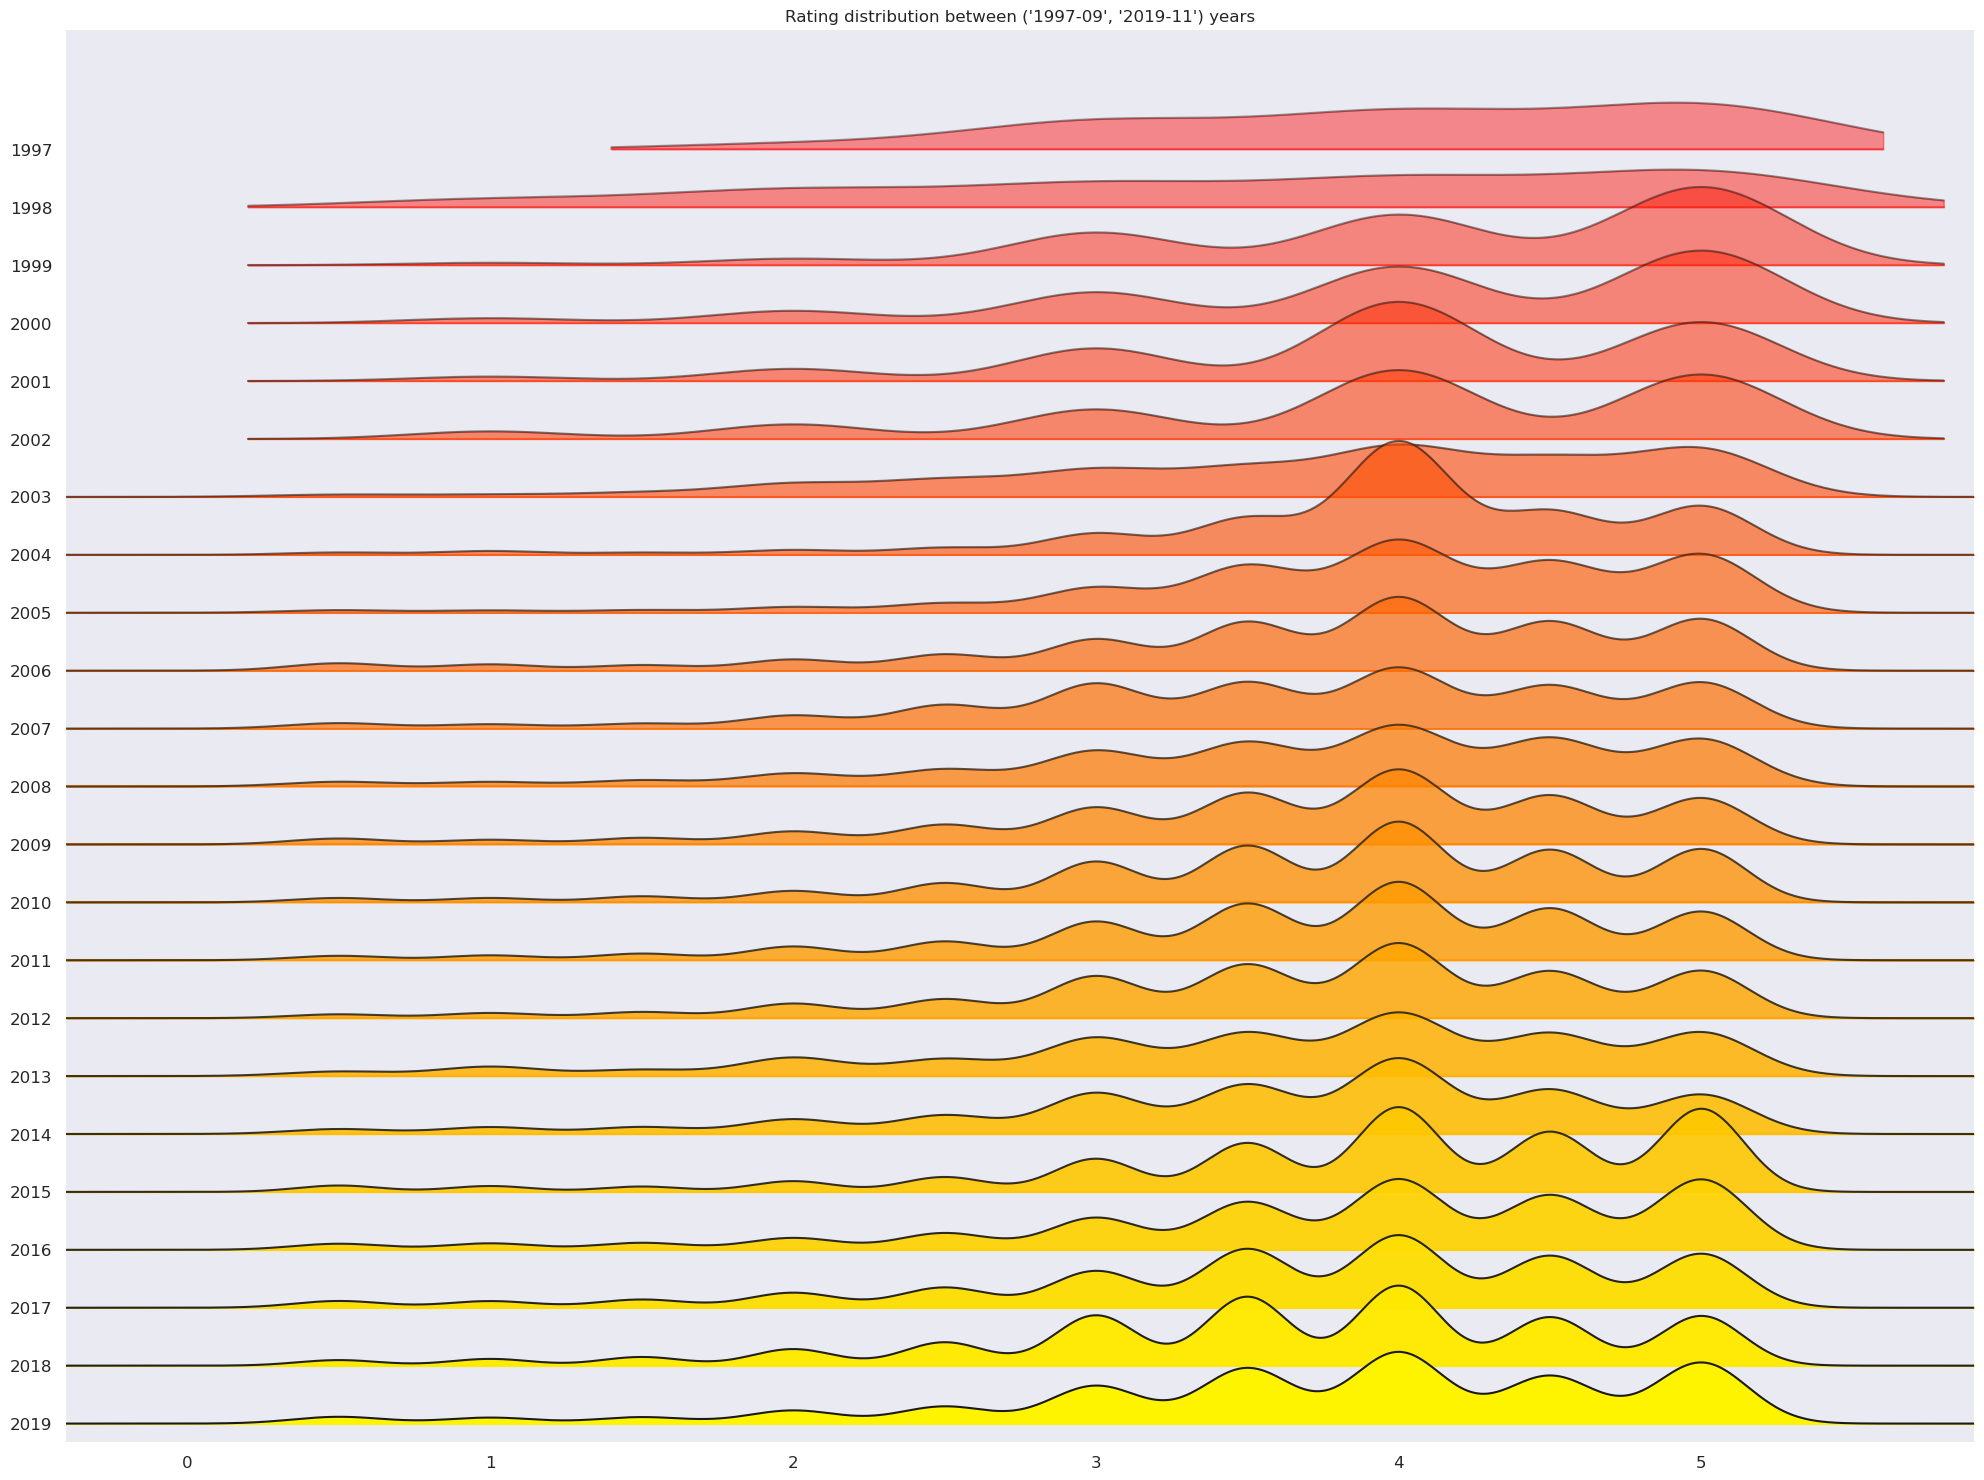

In [43]:
interactions['year'] = interactions.timestamp.dt.year

pl.xl_size()
pl.ridgeplot(
    interactions, 
    by     = 'year', 
    column = 'rating', 
    title  = f'Rating distribution between {years_range} years',
    kind   = 'kde',
)

# Peliculas y interacciones

# Correlaciones

In [44]:
complete_data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    )
complete_data = complete_data.loc[:, complete_data.columns!='id']
complete_data = complete_data.loc[:, complete_data.columns!='year']


complete_num_data = complete_data \
    .select_dtypes(include=np.number)

norm_complete_num_data = ut.norm(complete_num_data).drop(columns=['imdb_id'])

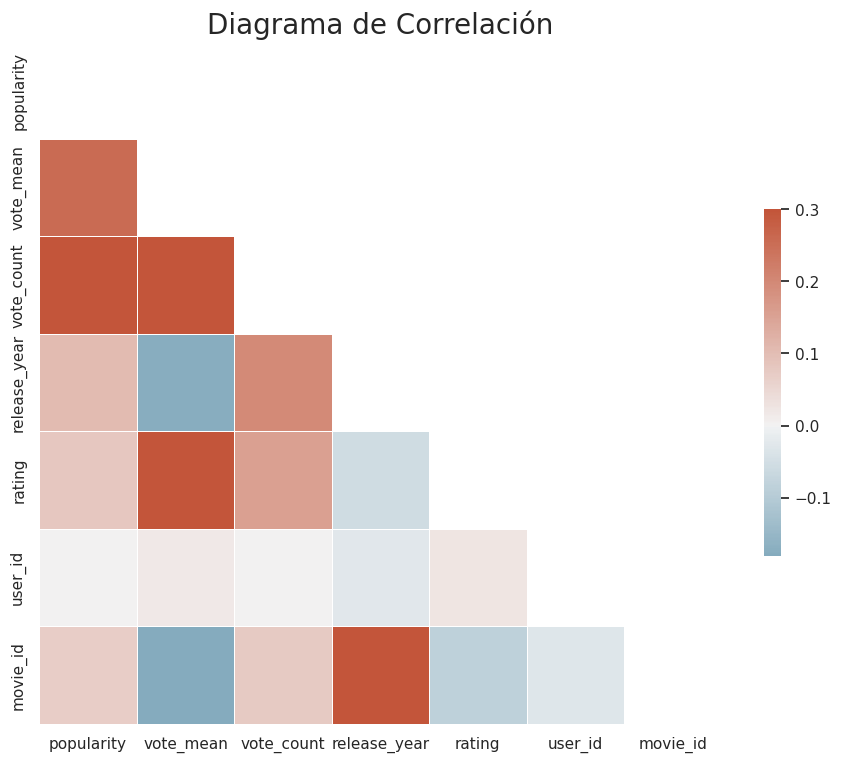

In [45]:
pl.correlations(norm_complete_num_data)

/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwa

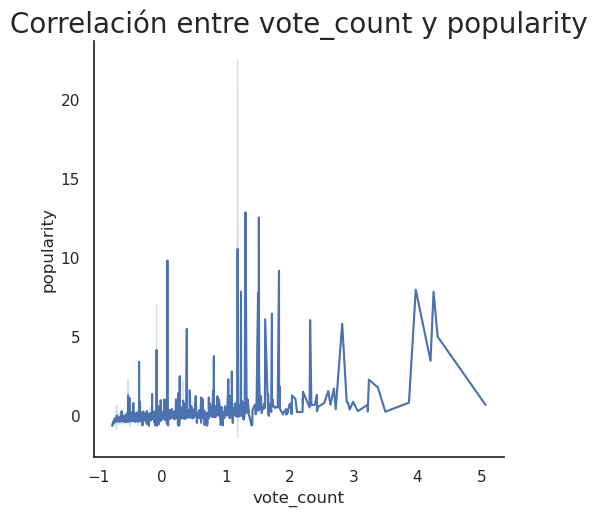

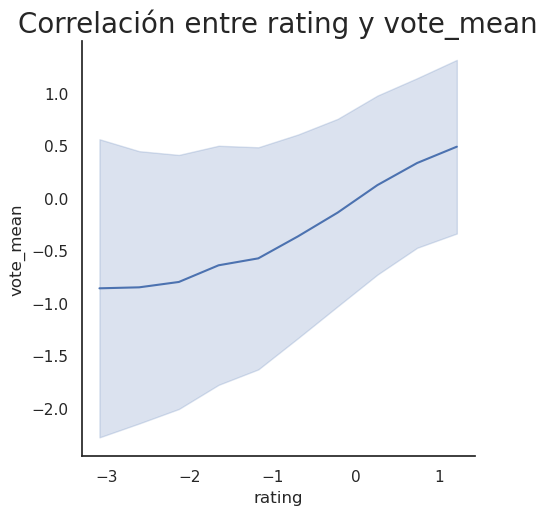

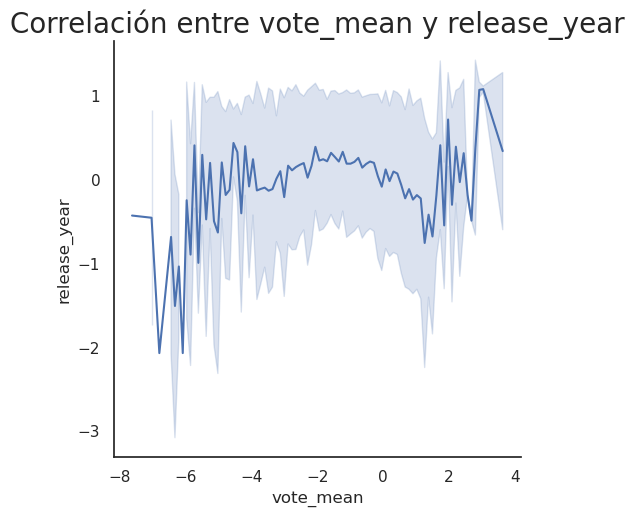

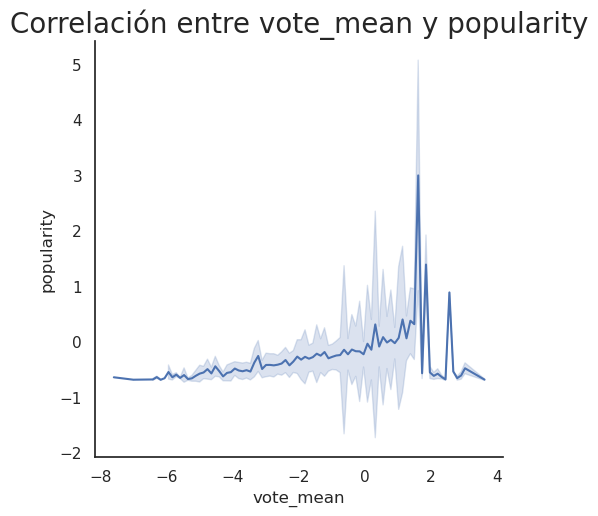

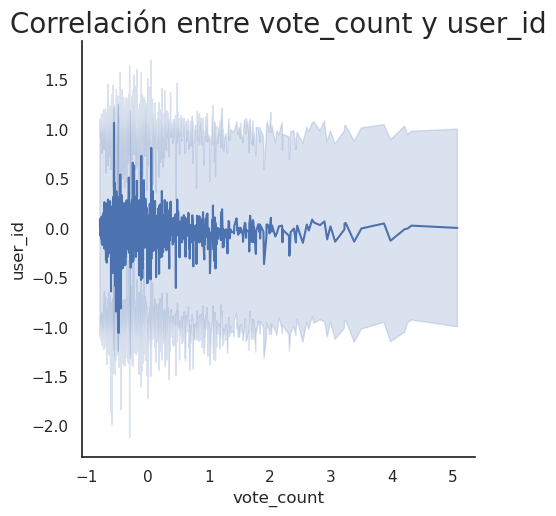

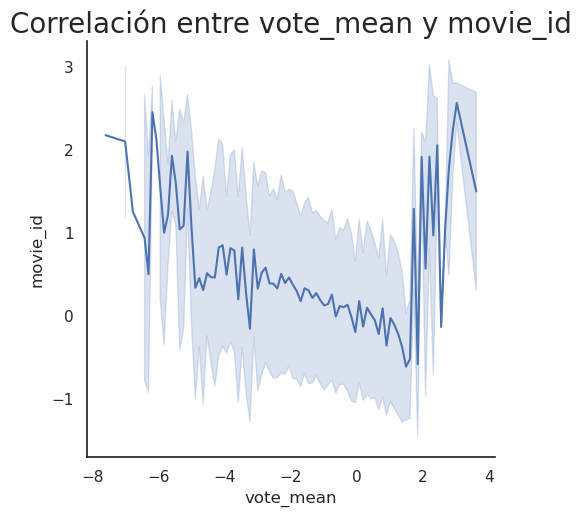

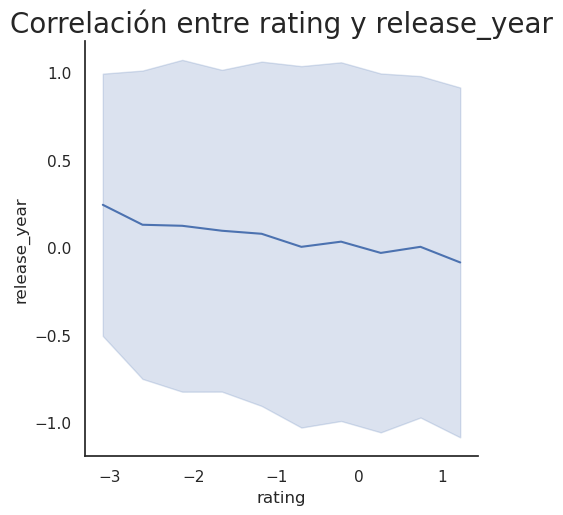

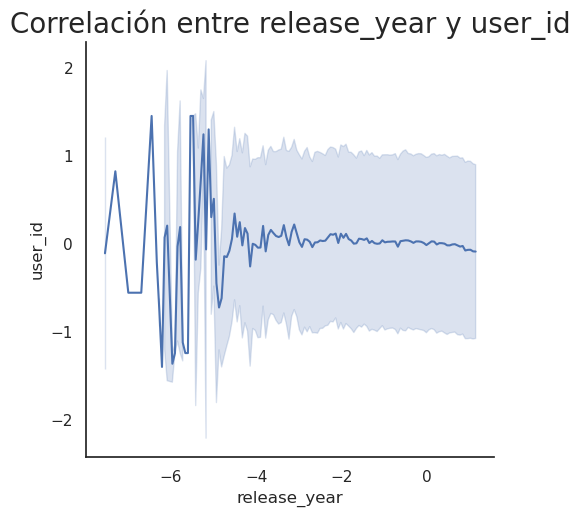

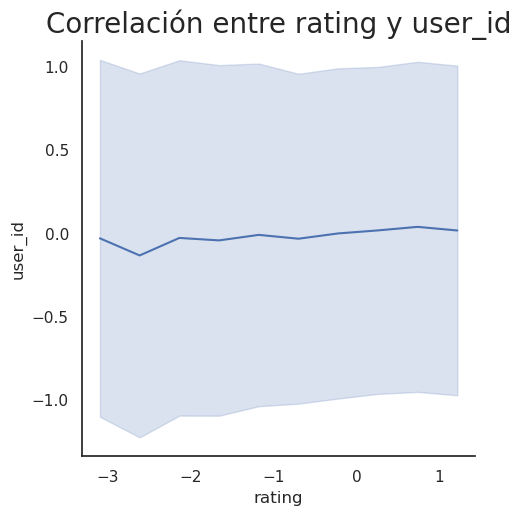

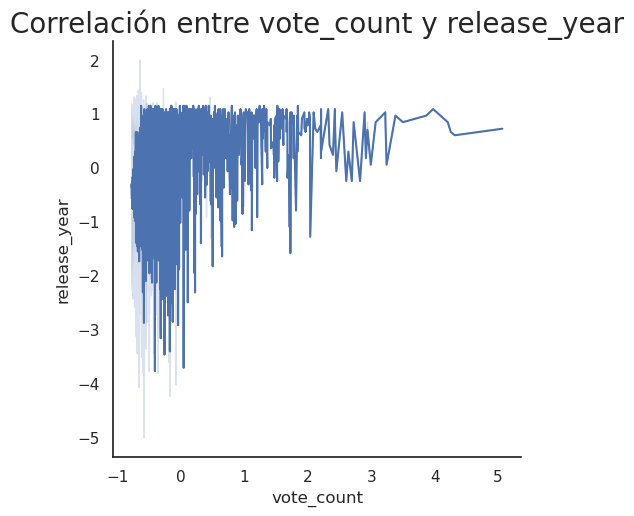

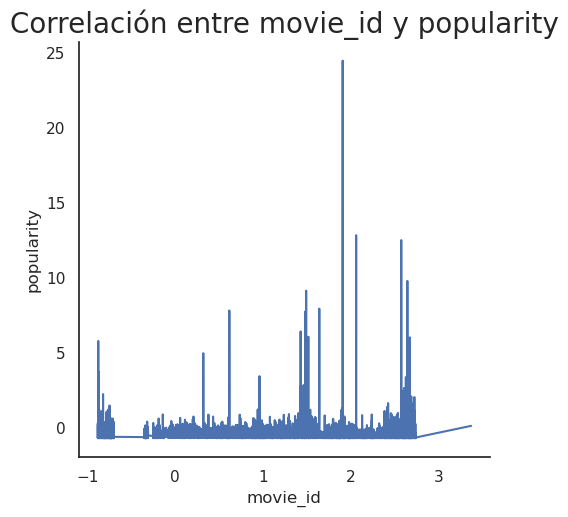

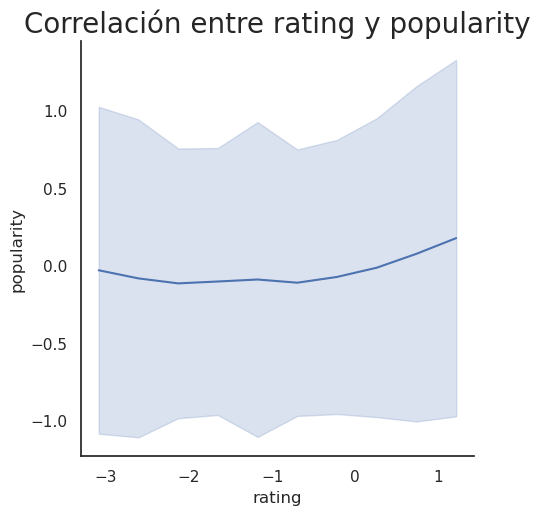

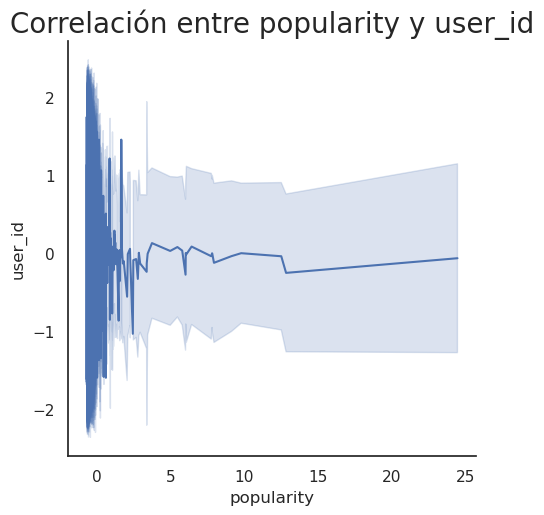

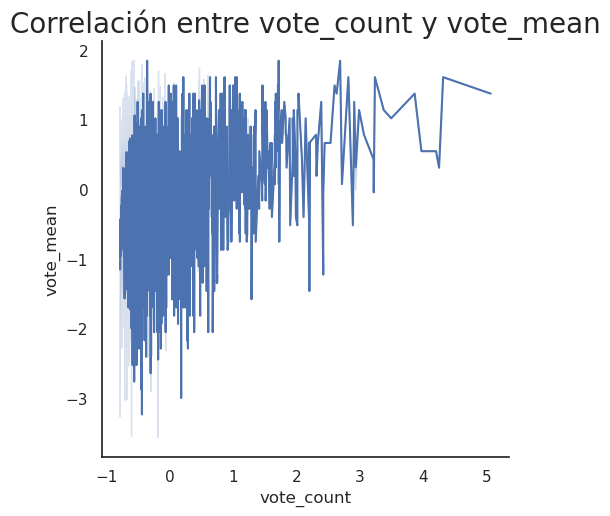

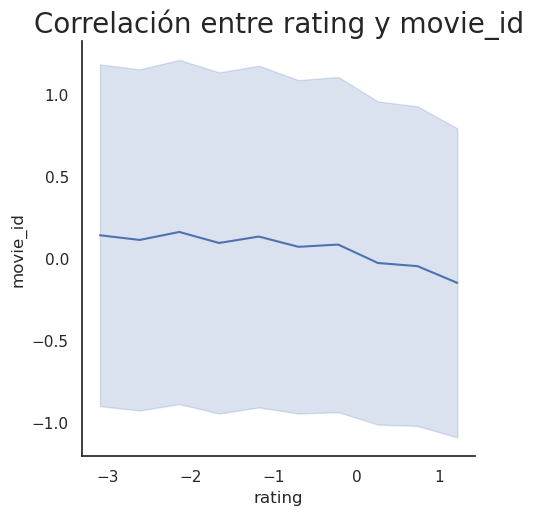

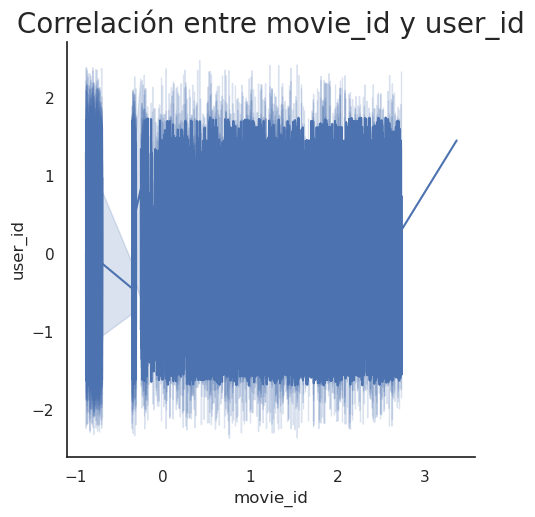

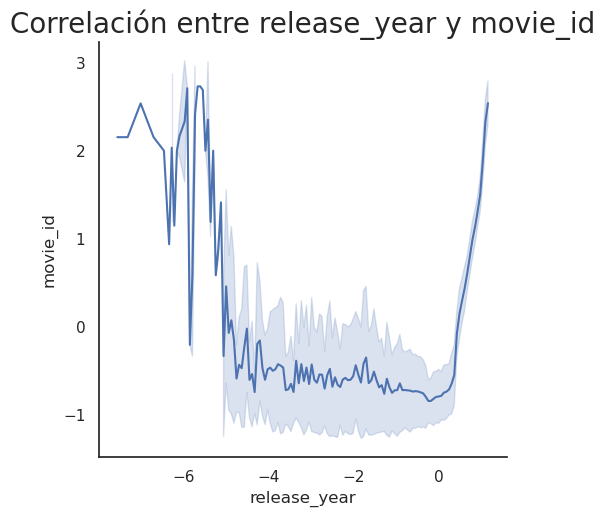

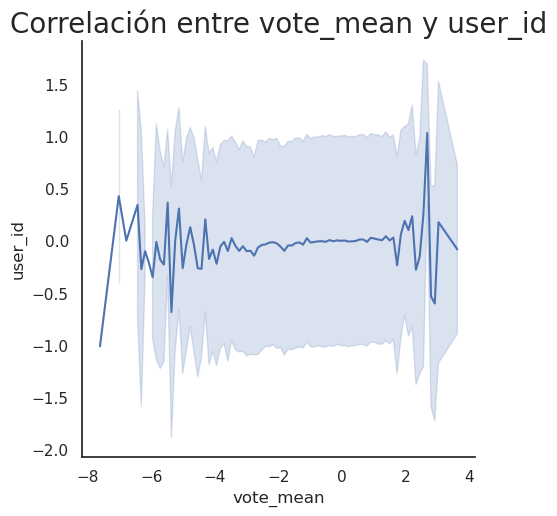

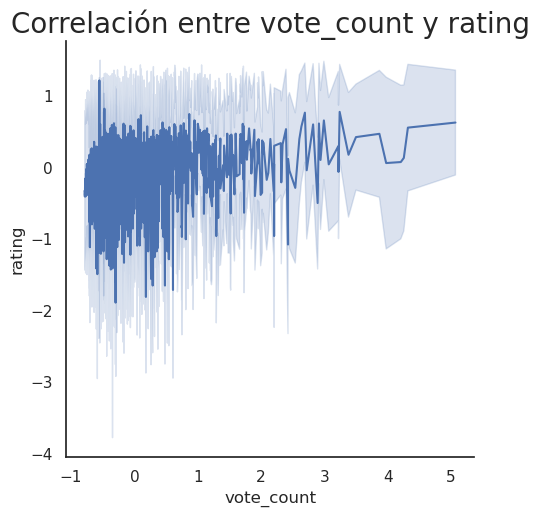

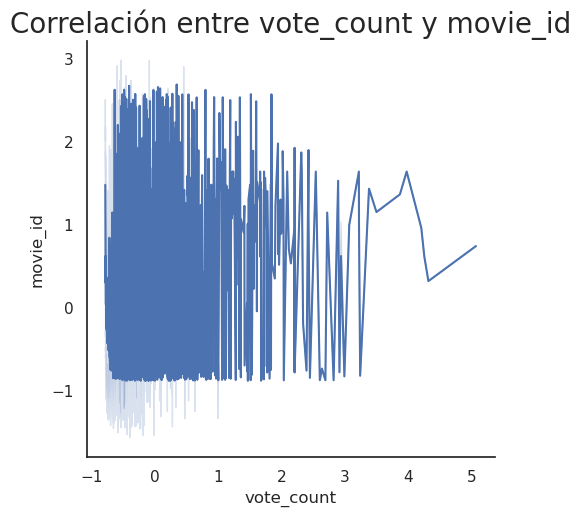

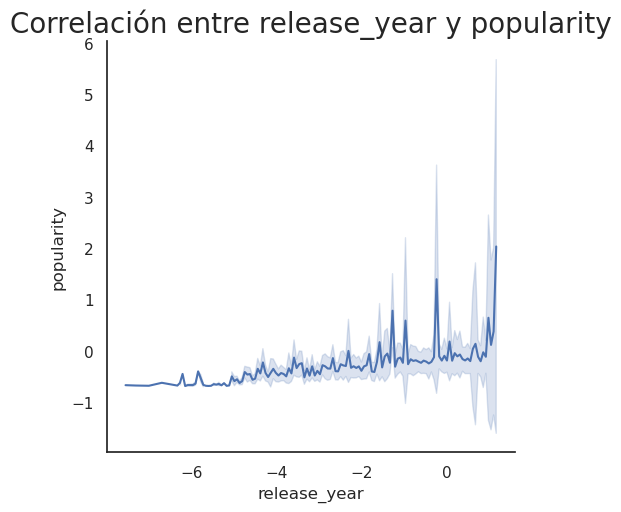

In [46]:
pl.plot_correlations(norm_complete_num_data)

# Componentes Principales

In [47]:
clusters = {
    0.5: '<2',
    1.0: '<2',
    1.5: '<2',

    2.0: '2-3.5',
    2.5: '2-3.5',
    3.0: '2-3.5',
    3.5: '2-3.5',

    4.0: '>4',
    4.5: '>4',
    5.0: '>4'
}


X  = norm_complete_num_data.copy().drop(columns=['rating'])
y  = complete_num_data.rating.apply(lambda x: clusters[x])

In [48]:
X

popularity  vote_mean  vote_count  release_year   user_id  movie_id
0         0.316054   0.904473    1.467631     -0.187050  0.437988 -0.879914
1         0.316054   0.904473    1.467631     -0.187050 -1.479127 -0.879914
2         0.316054   0.904473    1.467631     -0.187050  0.481083 -0.879914
3         0.316054   0.904473    1.467631     -0.187050  0.488152 -0.879914
4         0.316054   0.904473    1.467631     -0.187050  0.498130 -0.879914
...            ...        ...         ...           ...       ...       ...
199786   -0.674286   0.076730   -0.782814      0.117083 -1.239283  2.734098
199787   -0.685609  -3.470742   -0.782399      1.029480 -1.552536  2.733934
199788   -0.661650  -4.061987   -0.782814     -0.187050 -1.239283  2.734180
199789   -0.620400  -0.396266   -0.777410      1.151133  0.744108  2.733893
199790    0.128167   1.377469   -0.745819     -0.916967  1.455254  3.367387

[199791 rows x 6 columns]

In [49]:
y.value_counts()

>4       114024
2-3.5     74732
<2        11035
Name: rating, dtype: int64

In [50]:
summary = dt.PCAAnalisys.make_on(X, y, n_components = 3)

In [51]:
summary.observations(indexes=[1,2])[:,0]

array([ 1.28777307,  1.29655016,  1.28757577, ..., -2.07526272,
       -0.25775146,  0.50978155])

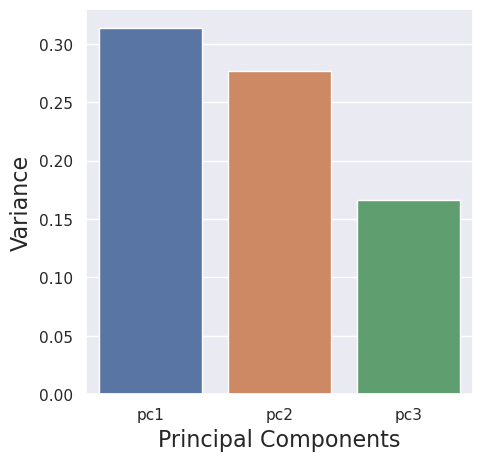

array([0.31391485, 0.27702888, 0.16615662])

In [52]:
pl.s_size()
summary.plot_explained_variance()
summary.explained_variance()

2023-11-07 18:50:43,537 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


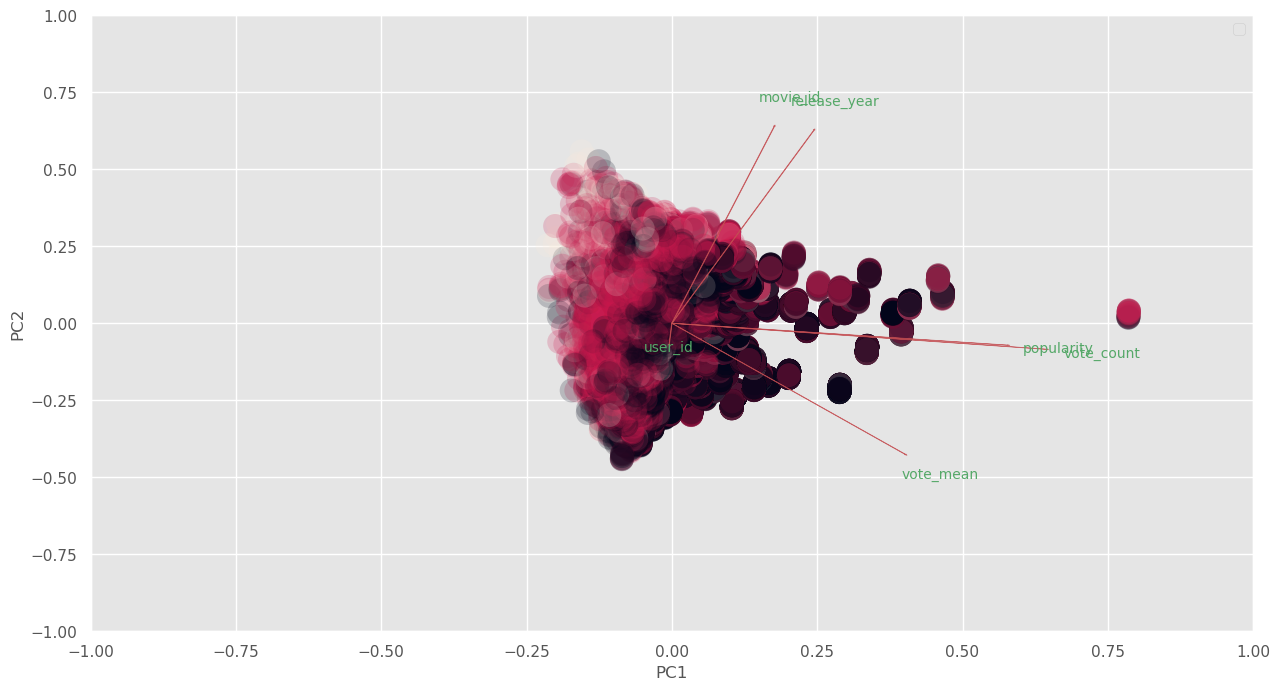

In [53]:
pl.l_size()
summary.biplot()

/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


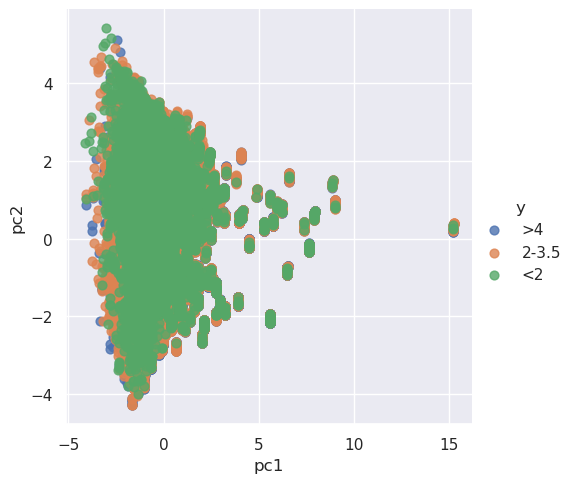

In [54]:
pl.l_size()
summary.plot_clusters()

## ¿Cuales son los generos de peliculas mas comunes?

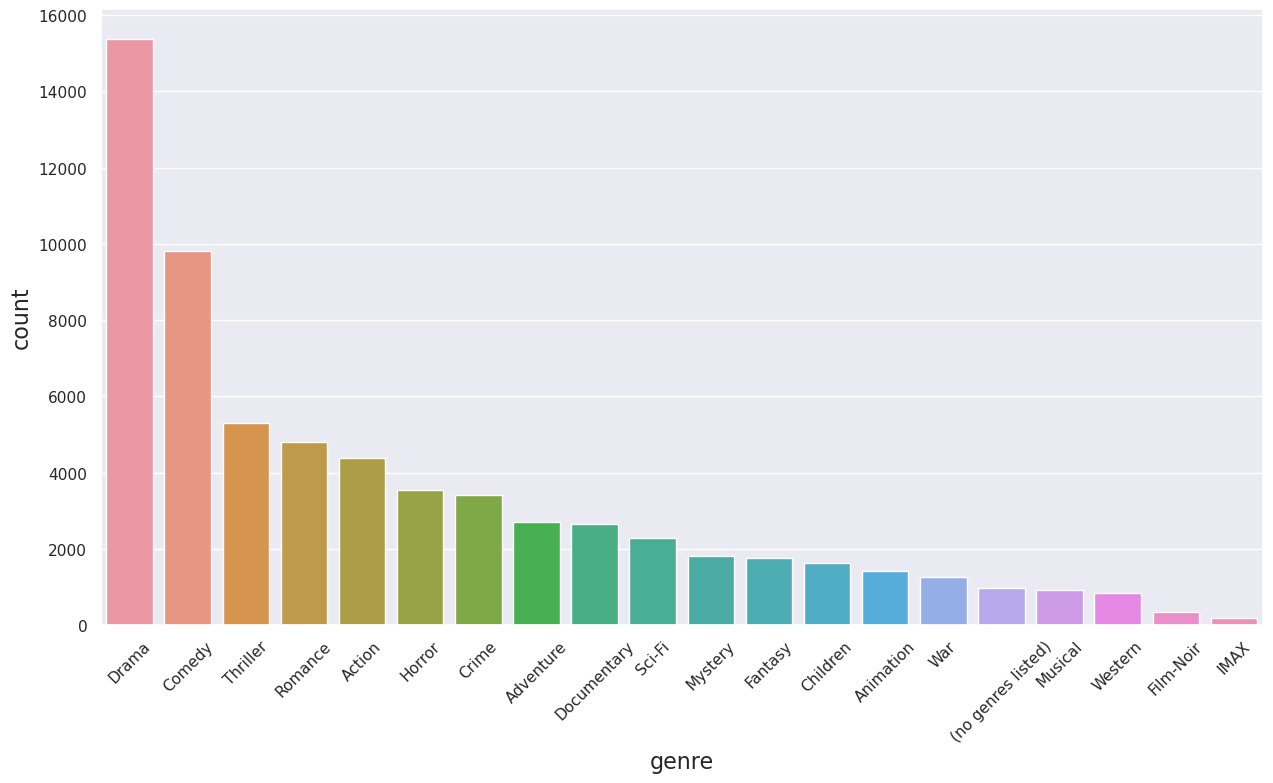

In [55]:
all_genres = lambda df: np.array([genre for genres in df['genres'].values for genre in genres])

genres_count = dt.frequency(all_genres(movies3),'genre')

pl.barplot(
    genres_count, 
    'genre', 
    'count', 
    figsize=(30, 6),
    x_rotation=45
)

## ¿Cuantas peliculas se estrenaron por año?

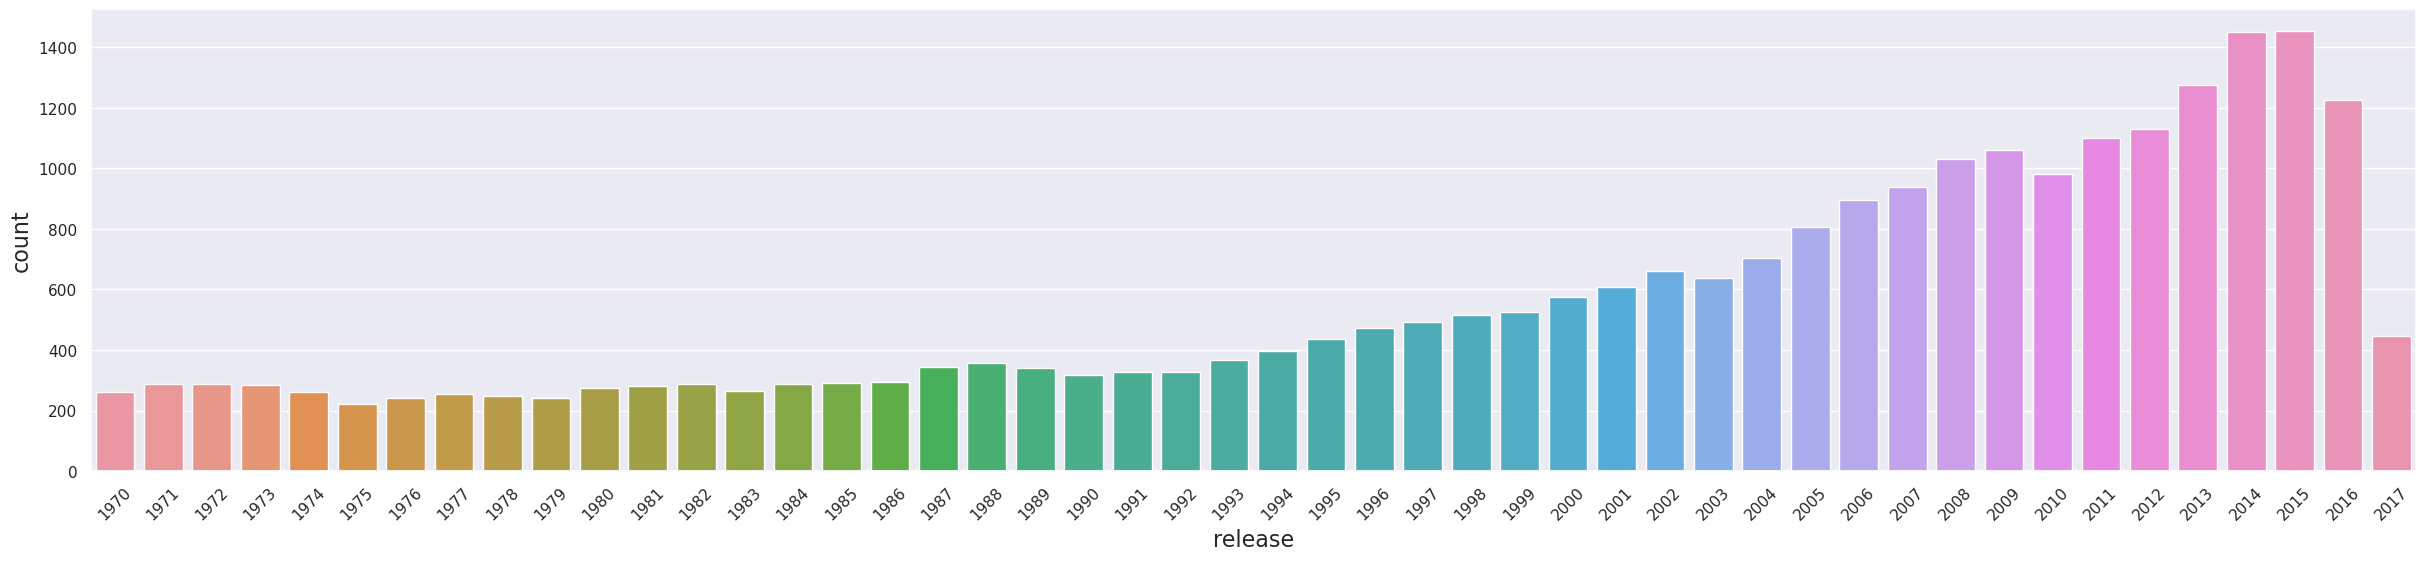

In [56]:
yearly_release_counts = movies3 \
    .groupby(movies3.release.dt.year) \
    .size() \
    .sort_values(ascending=False) \
    .reset_index(name='count')

pl.barplot(
    yearly_release_counts[yearly_release_counts.release >= 1970], 
    'release', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

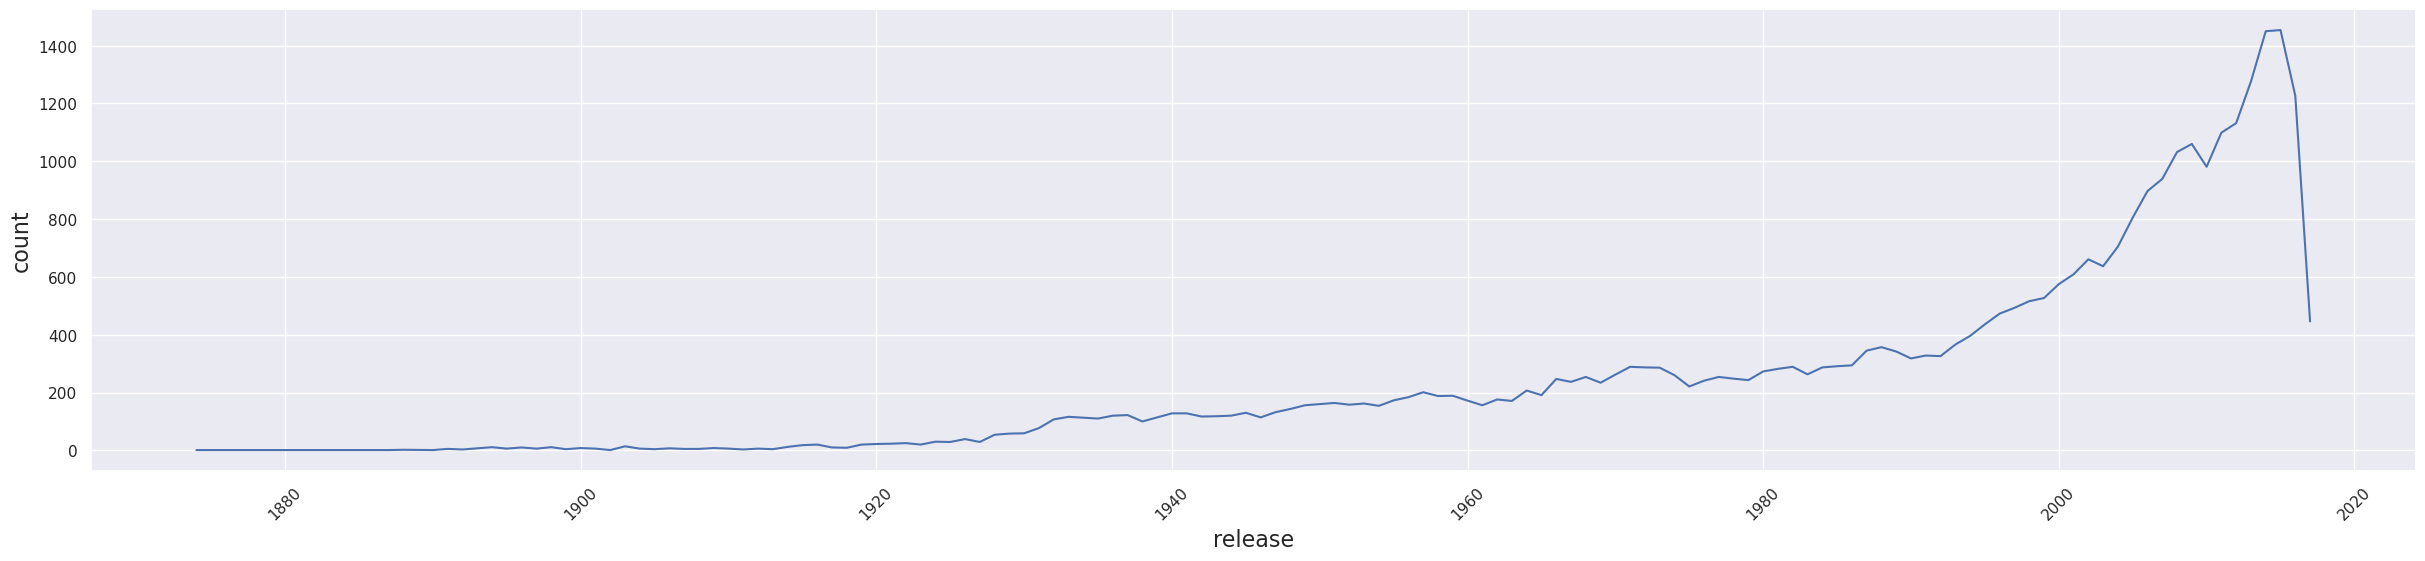

In [57]:
pl.lineplot(
    yearly_release_counts, 
    'release', 
    'count', 
    figsize=(30, 6),
    x_rotation=45
)

## ¿Cuantas peliculas se estrenaron por mes?

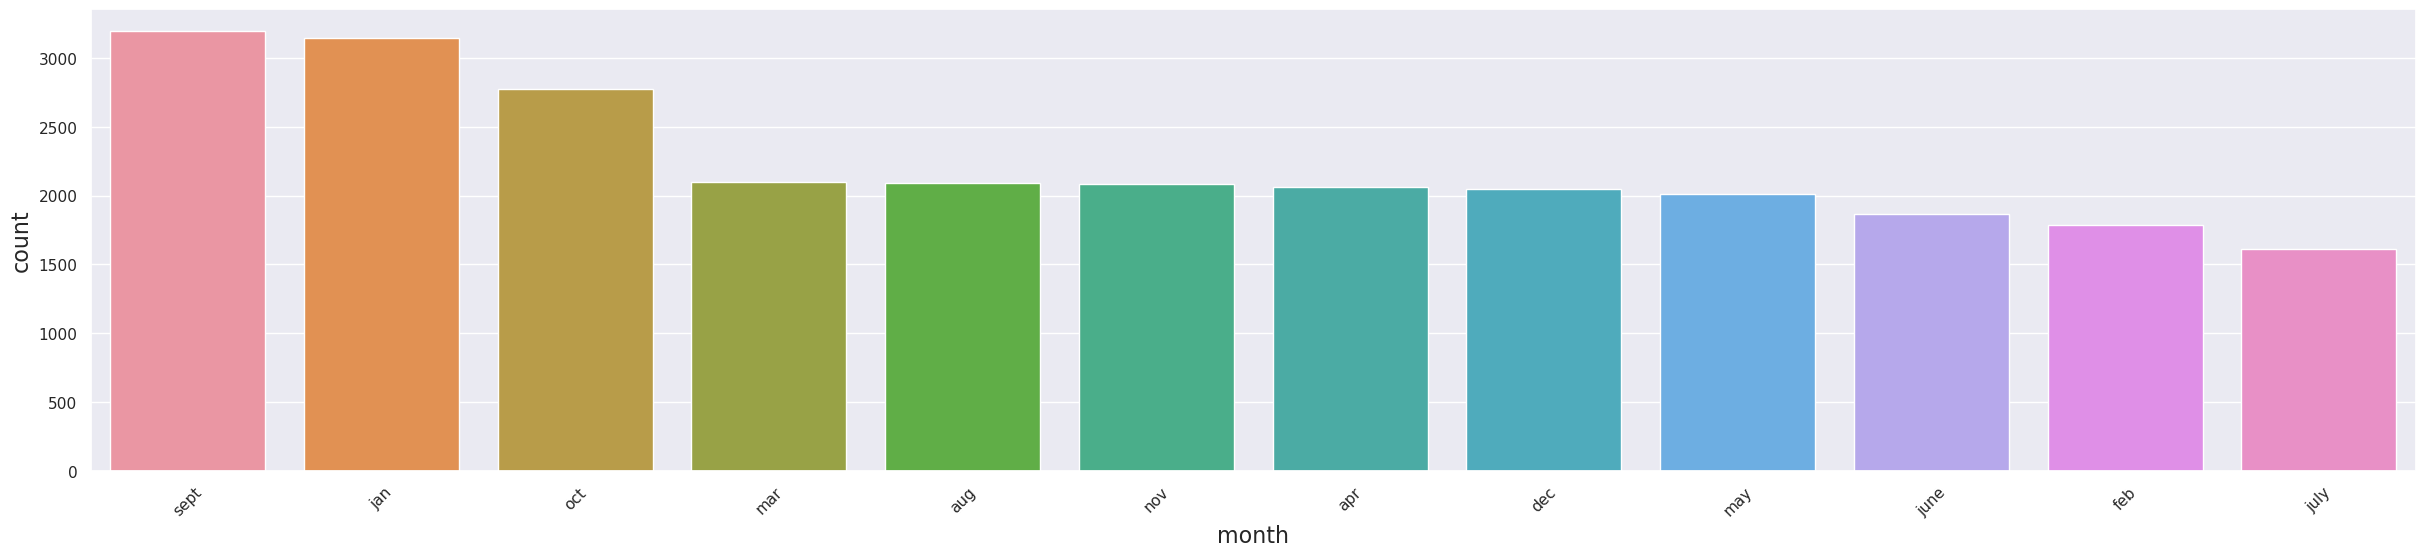

In [58]:
monthly_release_counts = movies3[movies3.release.dt.year >= 1970] \
    .groupby(movies3.release.dt.month) \
    .size() \
    .sort_values(ascending=False) \
    .reset_index(name='count')
    
monthly_release_counts['month'] = monthly_release_counts.release.apply(lambda it: dt.MONTHS[it-1])

pl.barplot(
    monthly_release_counts, 
    'month', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales son los dias de la seman preferidos para estrenar peliculas?

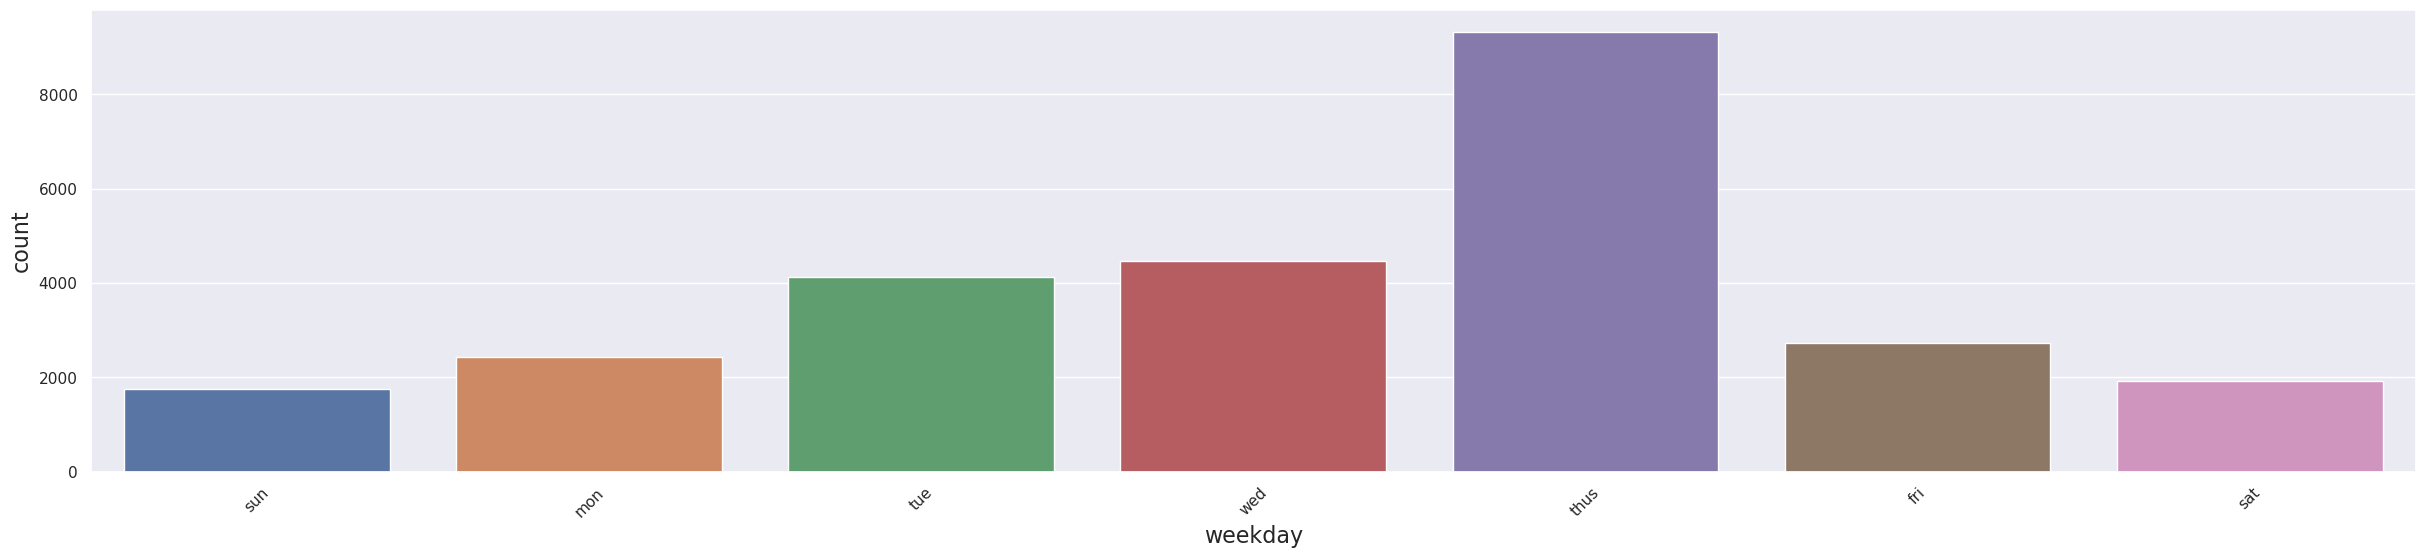

In [59]:
weekday_release_counts = movies3[movies3.release.dt.year >= 1970] \
    .groupby(movies3.release.dt.dayofweek) \
    .size() \
    .reset_index(name='count')
    
weekday_release_counts['weekday'] = weekday_release_counts \
    .release.apply(lambda it: dt.WEEK[it-1])


pl.barplot(
    weekday_release_counts, 
    'weekday', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor presupuesto?

/var/tmp/ipykernel_461696/3256653339.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = movies \


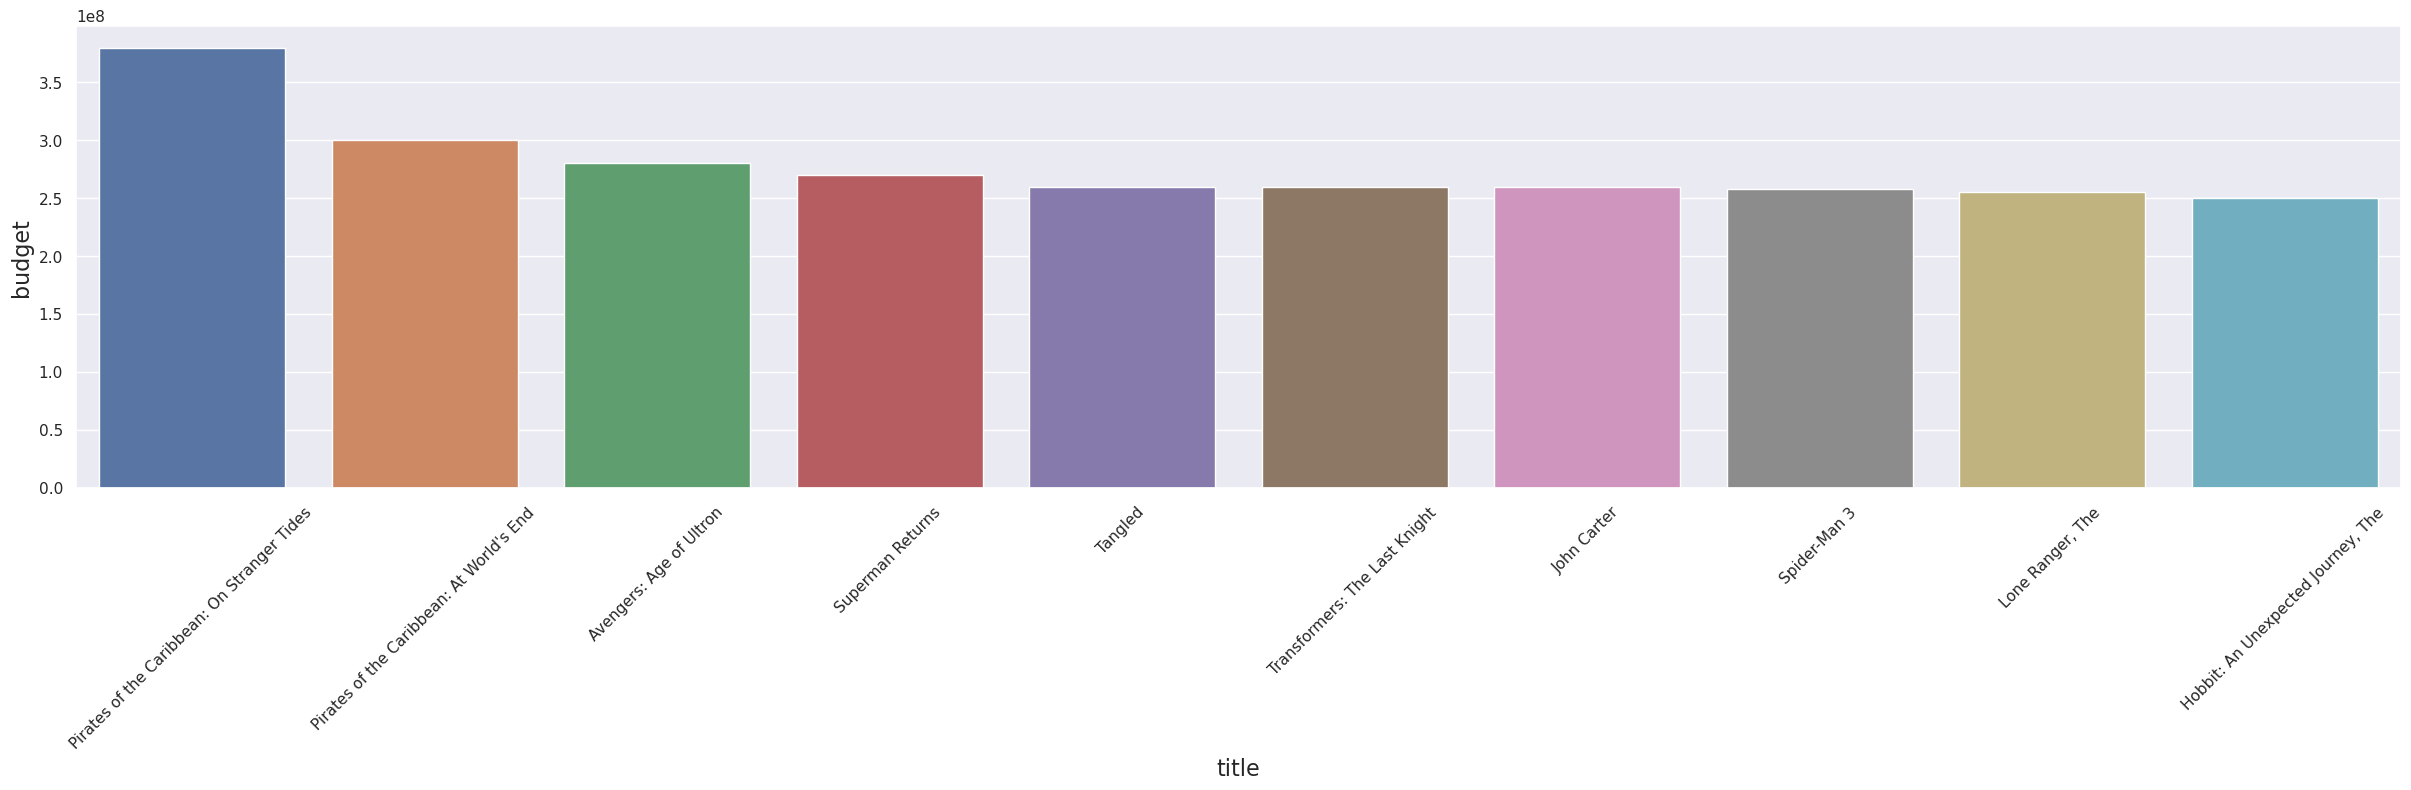

In [60]:
data = movies \
    .sort_values(by=['budget'], ascending=False) \
    [['title', 'budget']] \
    [movies.budget > 0][:10]

pl.barplot(
    data, 
    'title', 
    'budget',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor popularidad?

/var/tmp/ipykernel_461696/1458916326.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = movies3 \


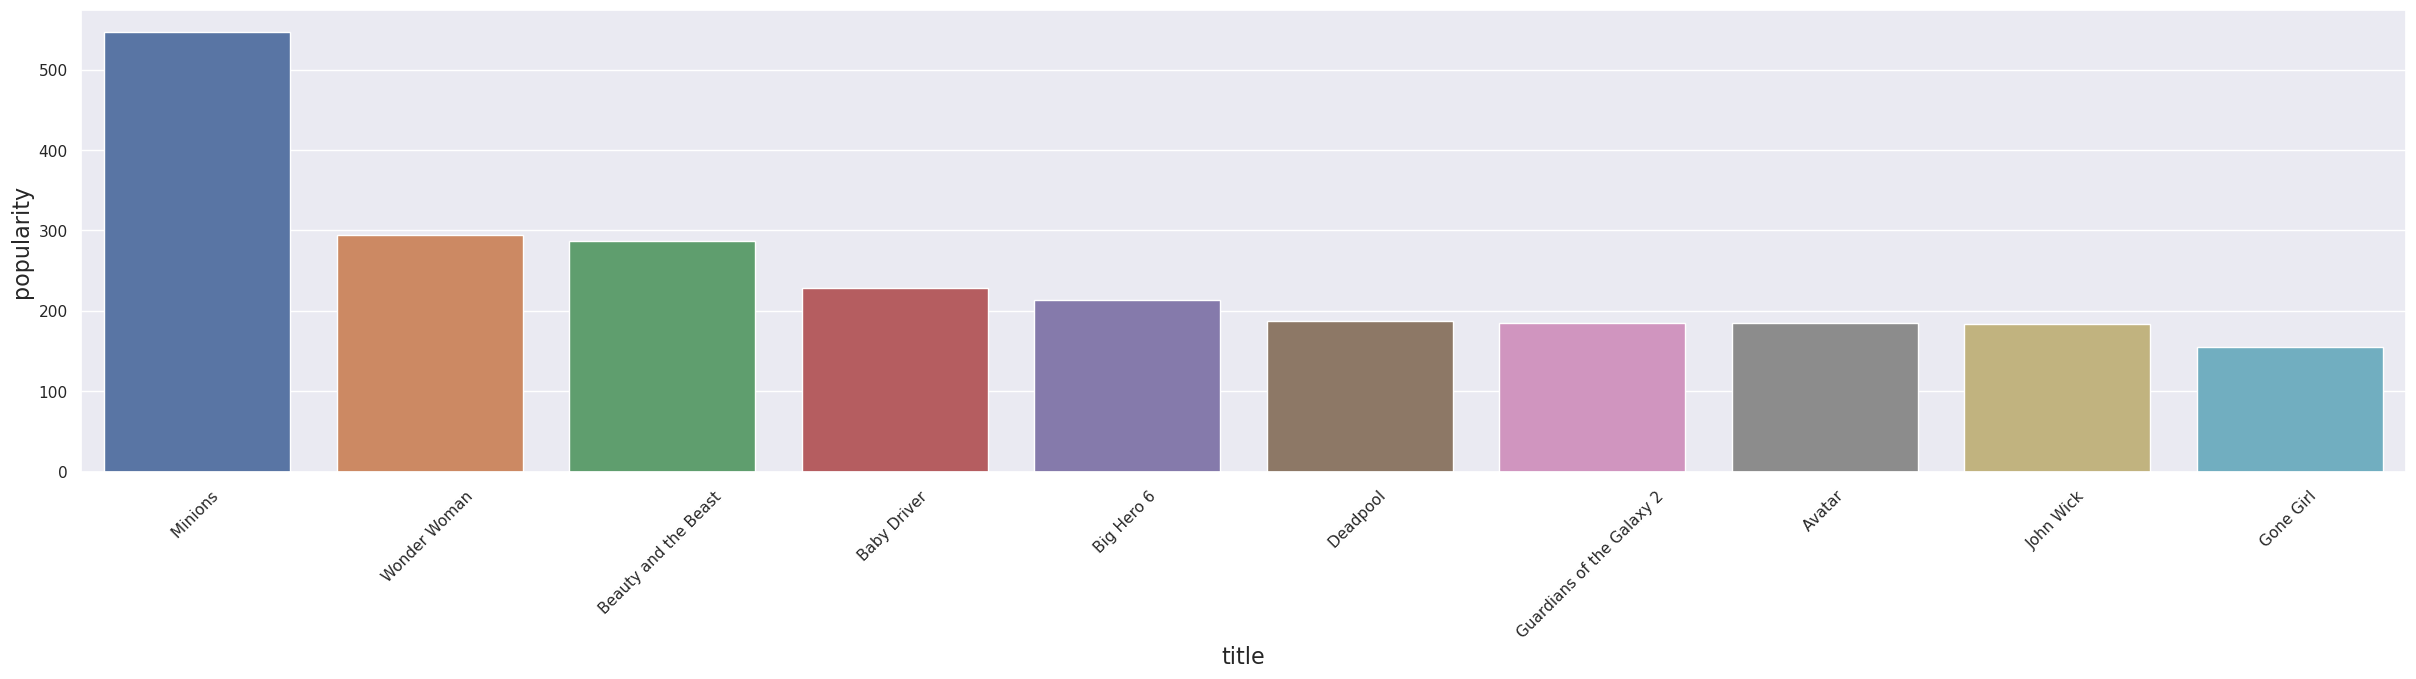

In [61]:
data = movies3 \
    .sort_values(by=['popularity'], ascending=False) \
    [['title', 'popularity']] \
    [movies3.popularity > 0][:10]

pl.barplot(
    data, 
    'title', 
    'popularity',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor promedio de votacion?

/var/tmp/ipykernel_461696/4246731389.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = movies3 \


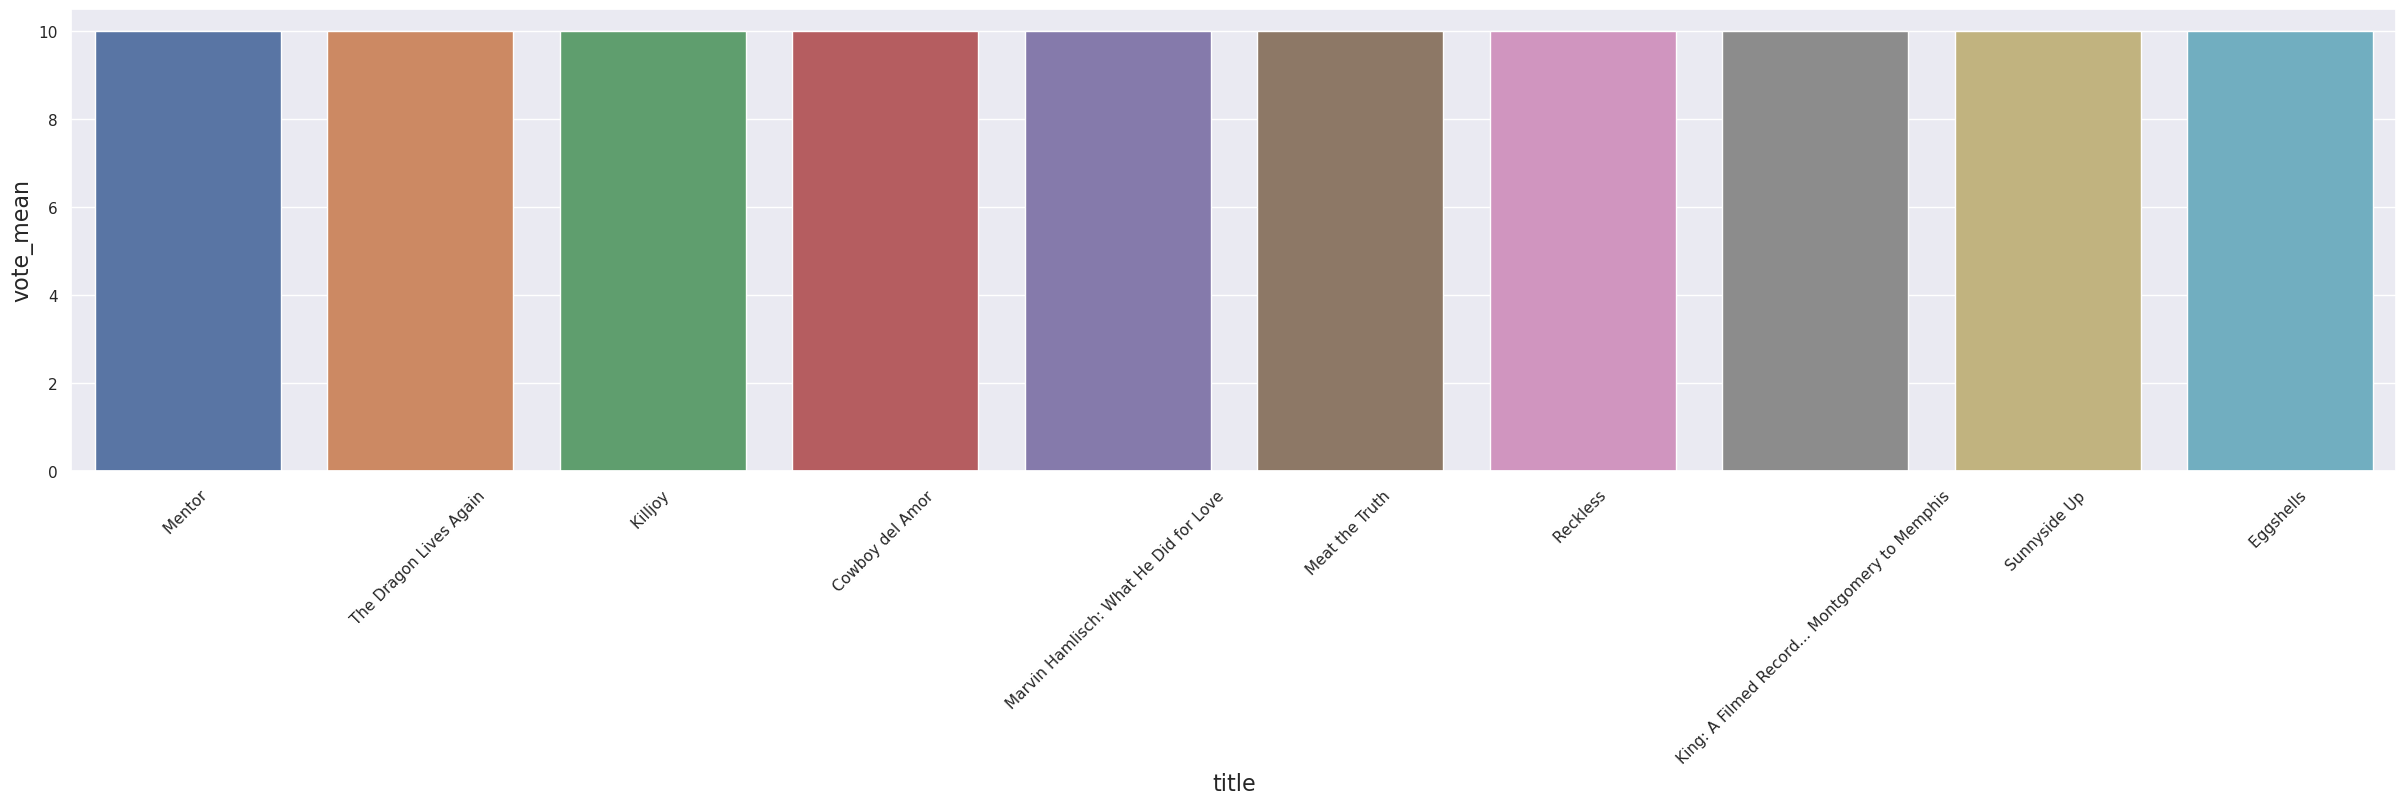

In [62]:
data = movies3 \
    .sort_values(by=['vote_mean'], ascending=False) \
    [['title', 'vote_mean']] \
    [movies3.vote_mean > 0][:10]

pl.barplot(
    data, 
    'title', 
    'vote_mean',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor cantidad de votaciones?

/var/tmp/ipykernel_461696/1707055543.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = movies3 \


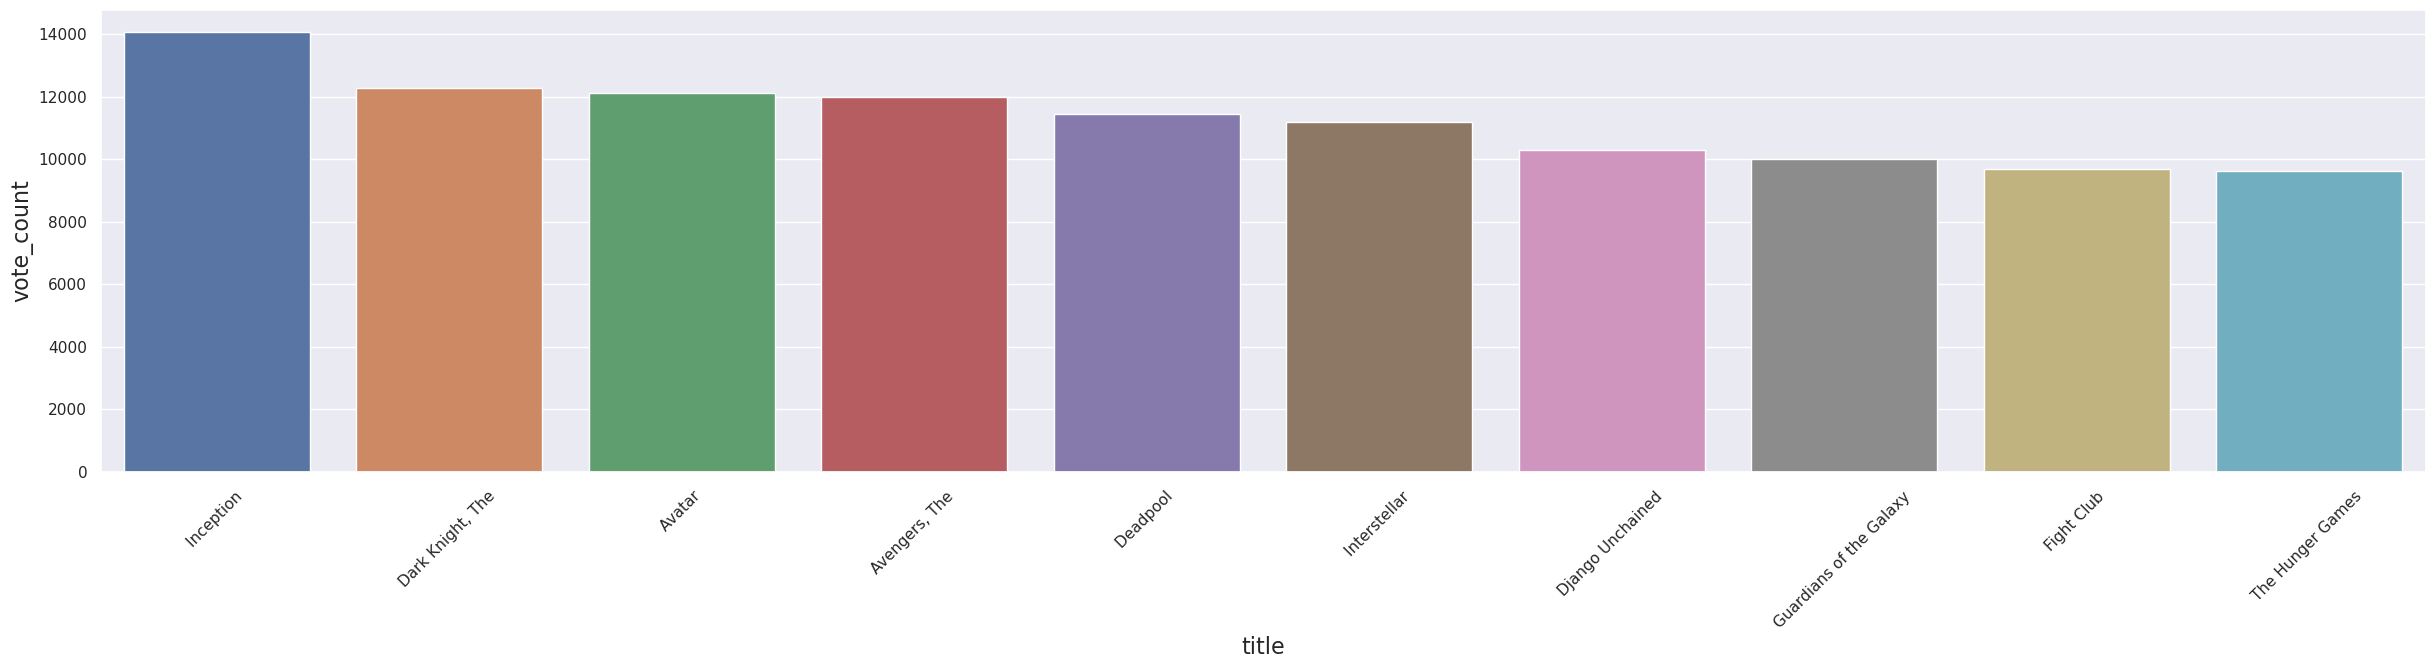

In [63]:
data = movies3 \
    .sort_values(by=['vote_count'], ascending=False) \
    [['title', 'vote_count']] \
    [movies3.vote_mean > 0][:10]

pl.barplot(
    data, 
    'title', 
    'vote_count',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor rating y votaciones?

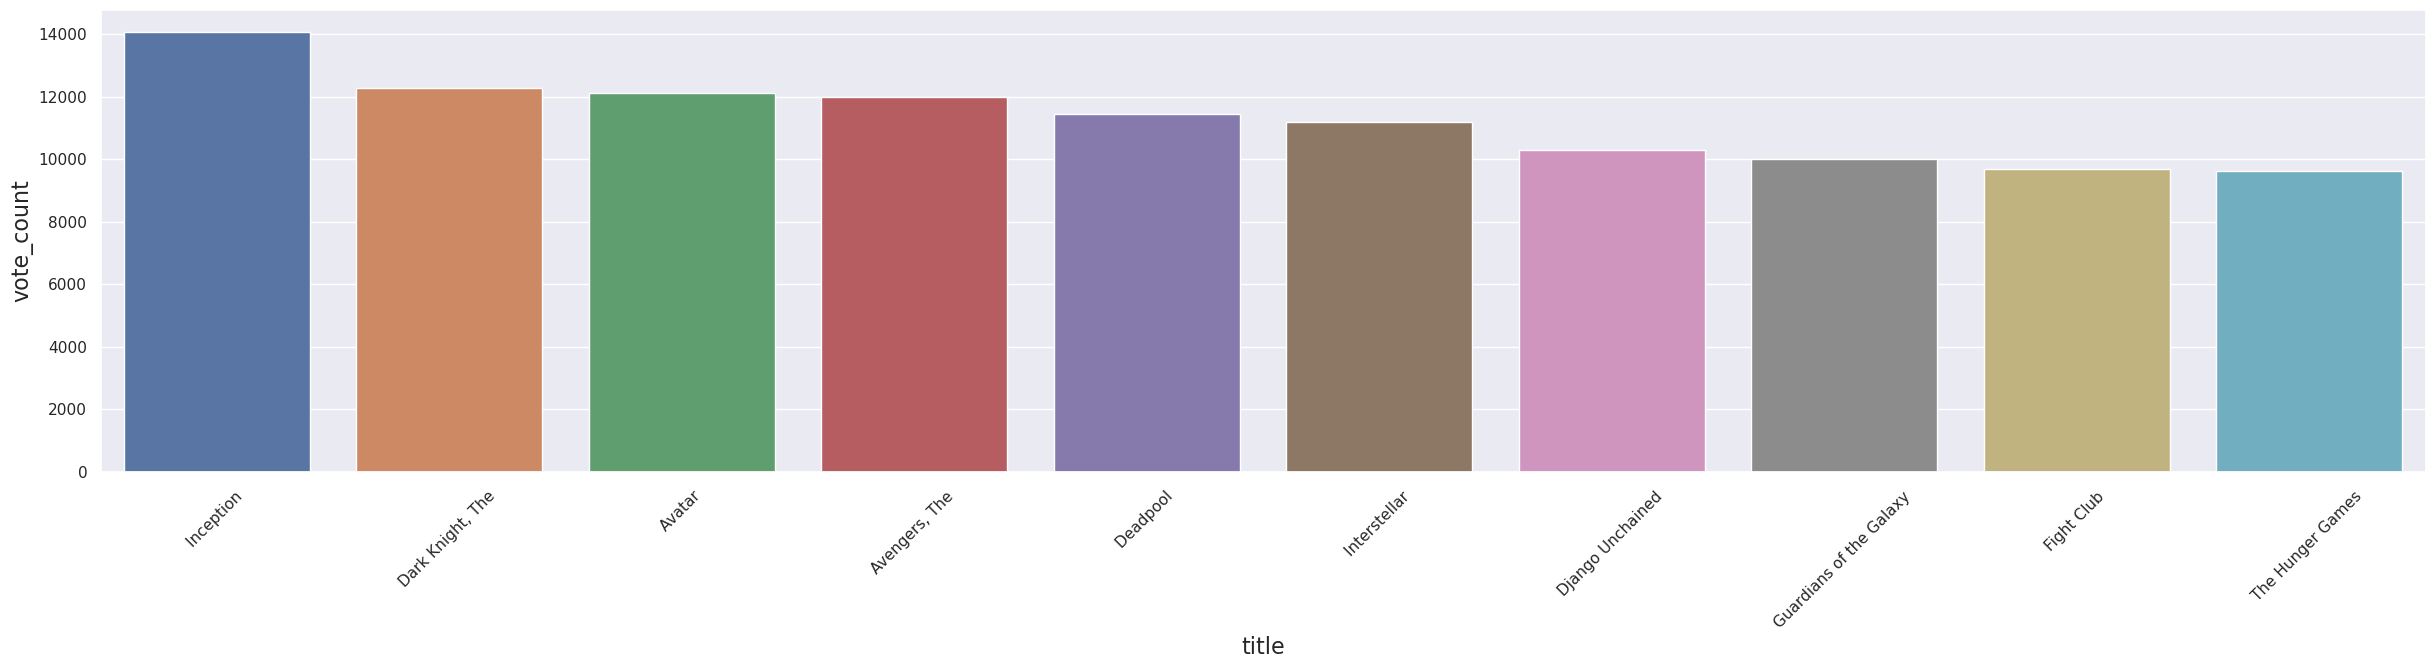

In [64]:
data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    ) \
    .sort_values(by=['rating', 'vote_count'], ascending=False) \
    [['title', 'rating', 'vote_count']] \
    .drop_duplicates() \
    [:10]

pl.barplot(
    data, 
    'title', 
    'vote_count',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor rating y popularidad?

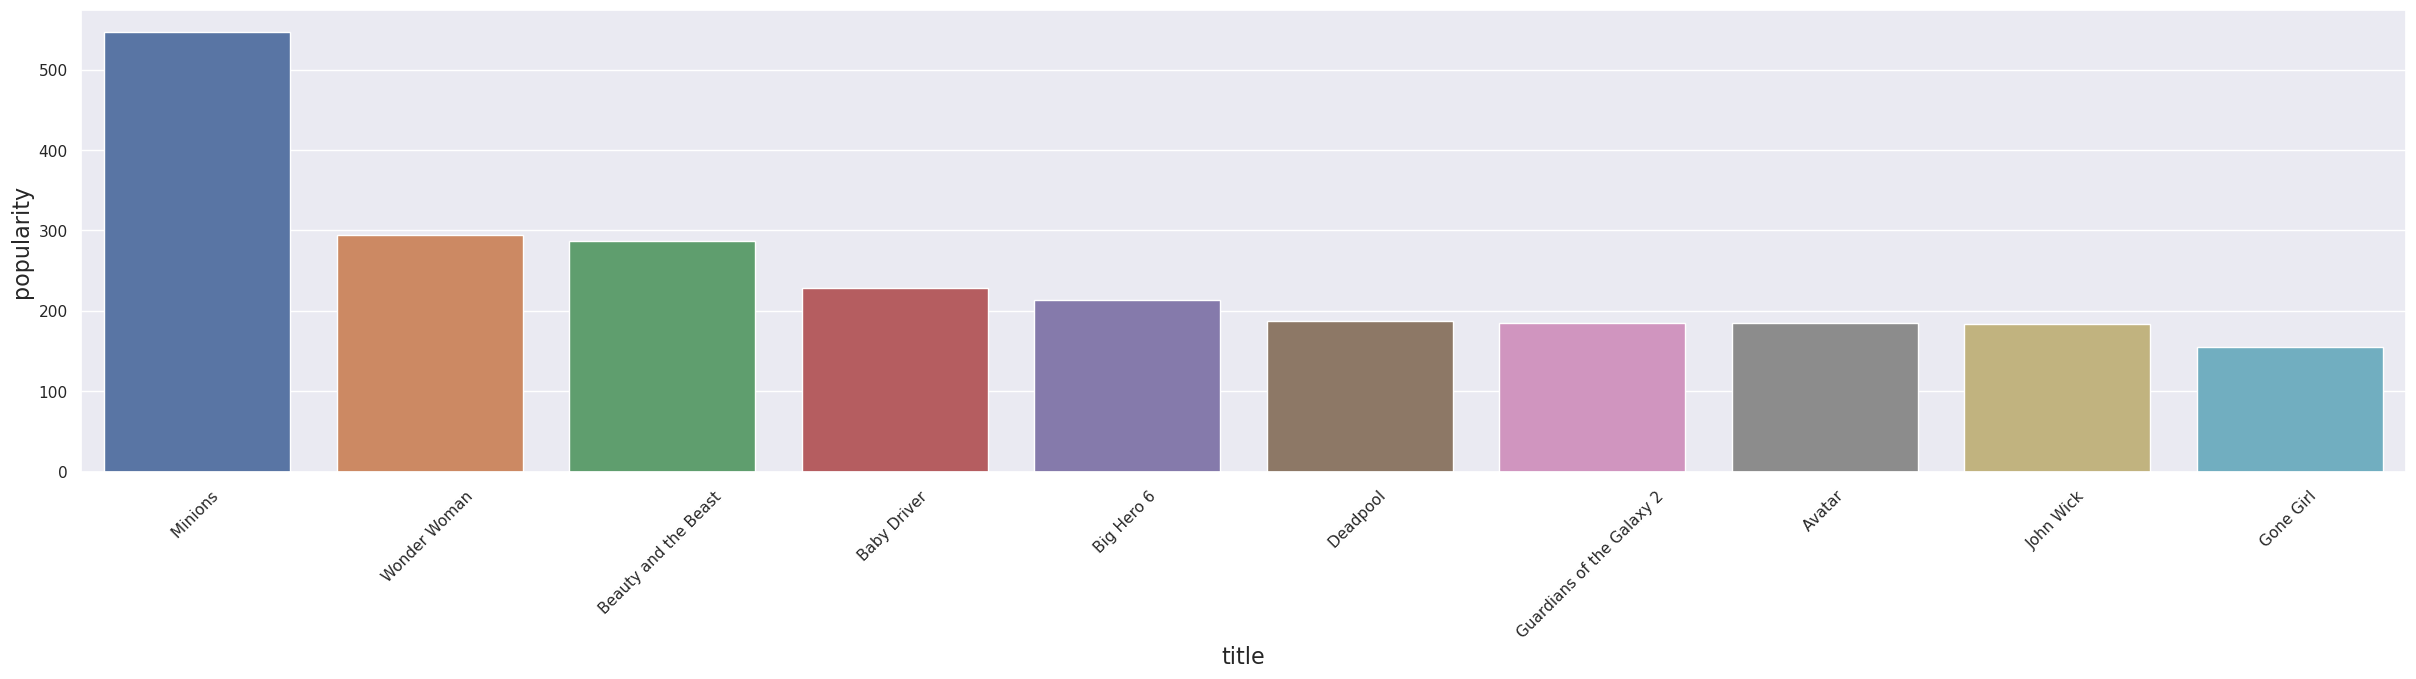

In [65]:
data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    ) \
    .sort_values(by=['rating', 'popularity'], ascending=False) \
    [['title', 'rating', 'popularity']] \
    .drop_duplicates() \
    [:10]

pl.barplot(
    data, 
    'title', 
    'popularity',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cual es la cantidad de peliculas estranada por año para cada genero?

/home/adrian/development/personal/maestria/thesis-paper/notebooks/../lib/data/utils.py:56: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data =  df.drop(column, 1).join(df[column].str.join('|').str.get_dummies())


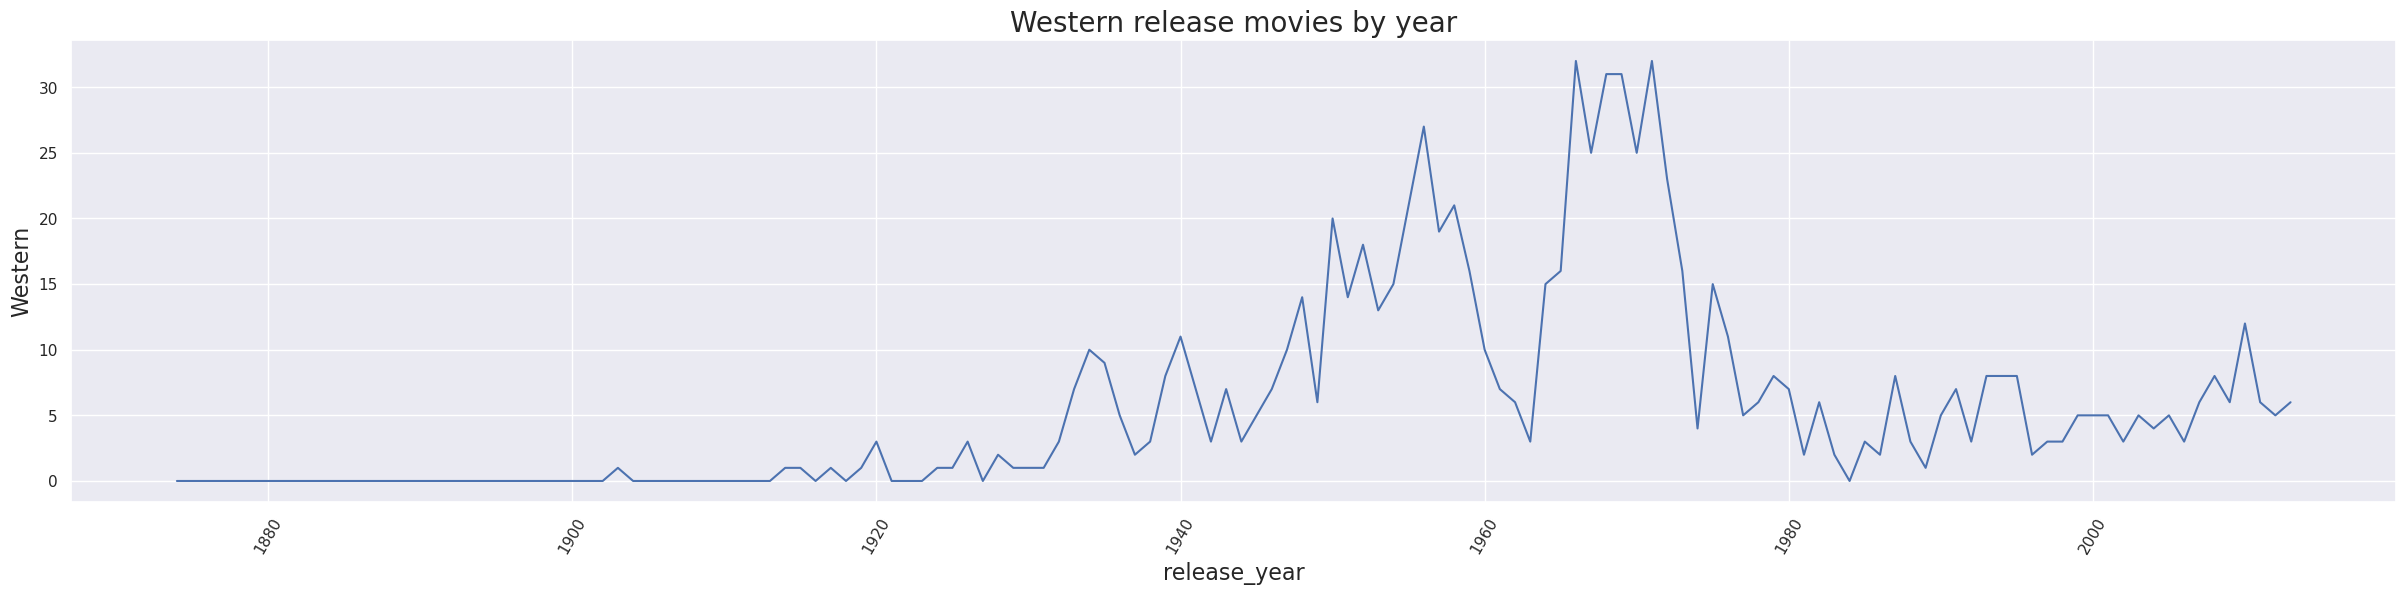

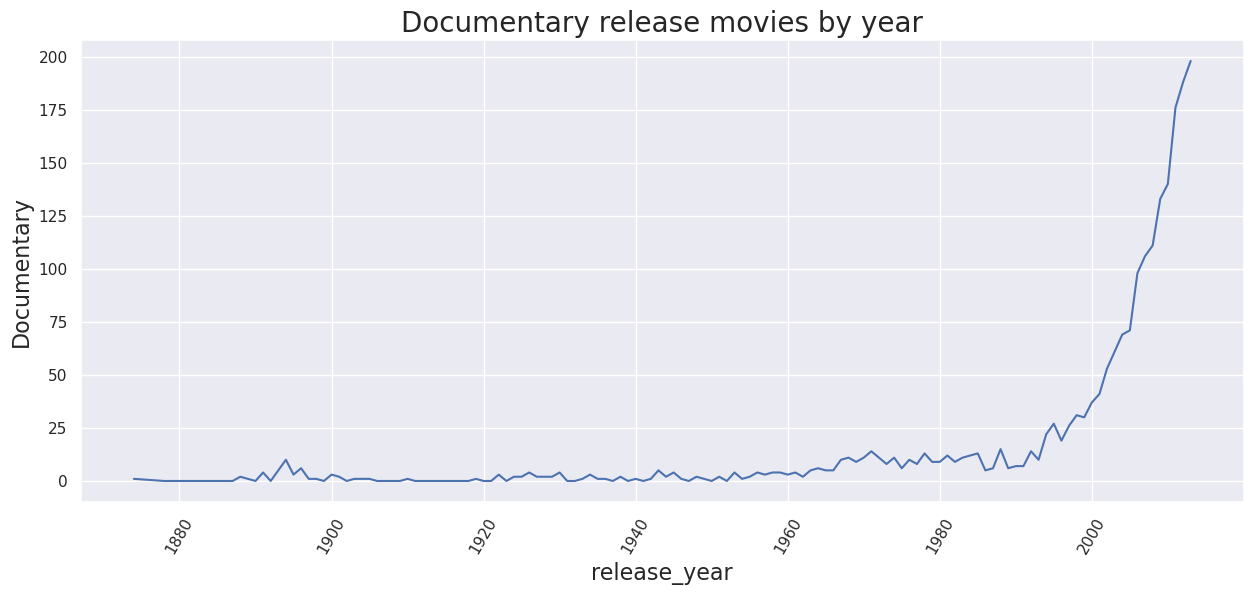

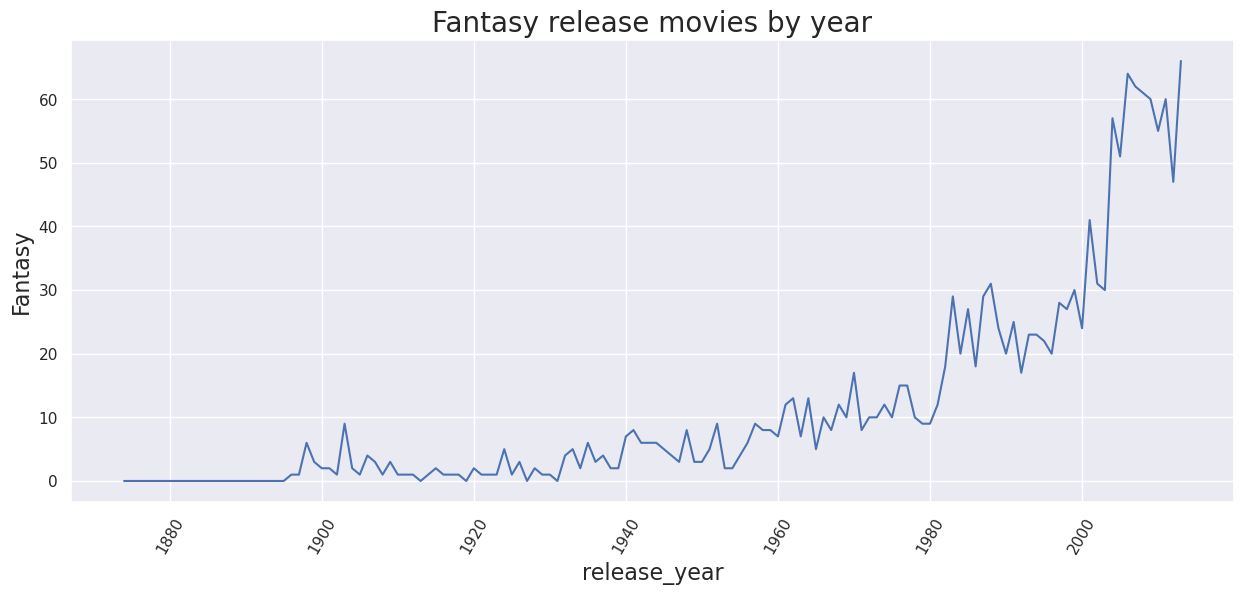

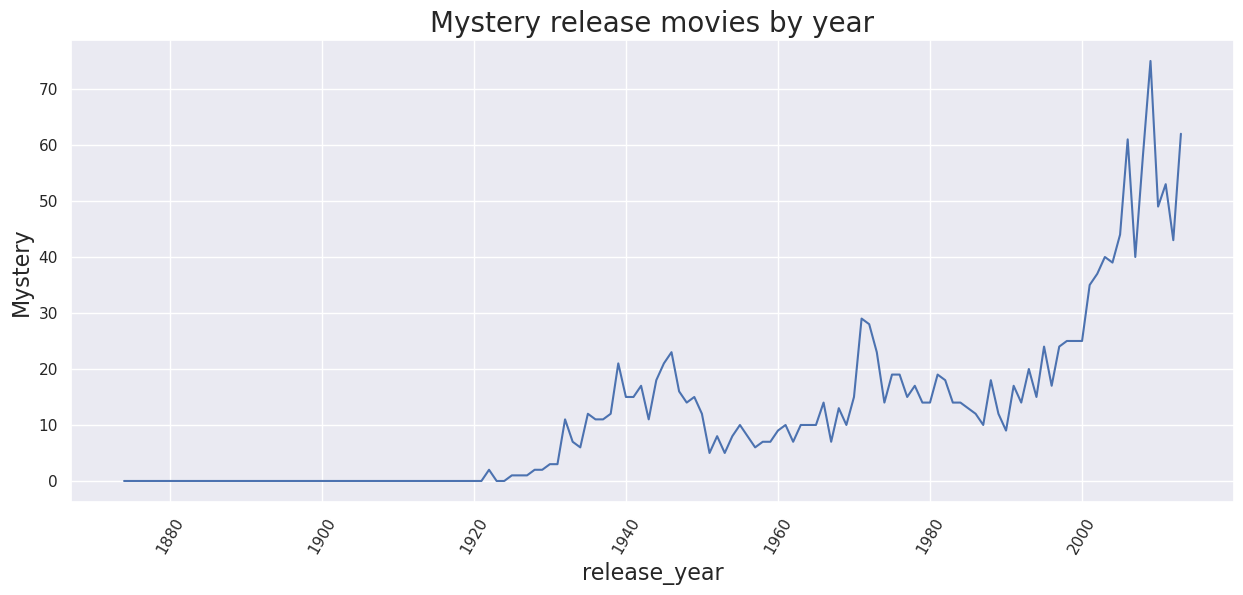

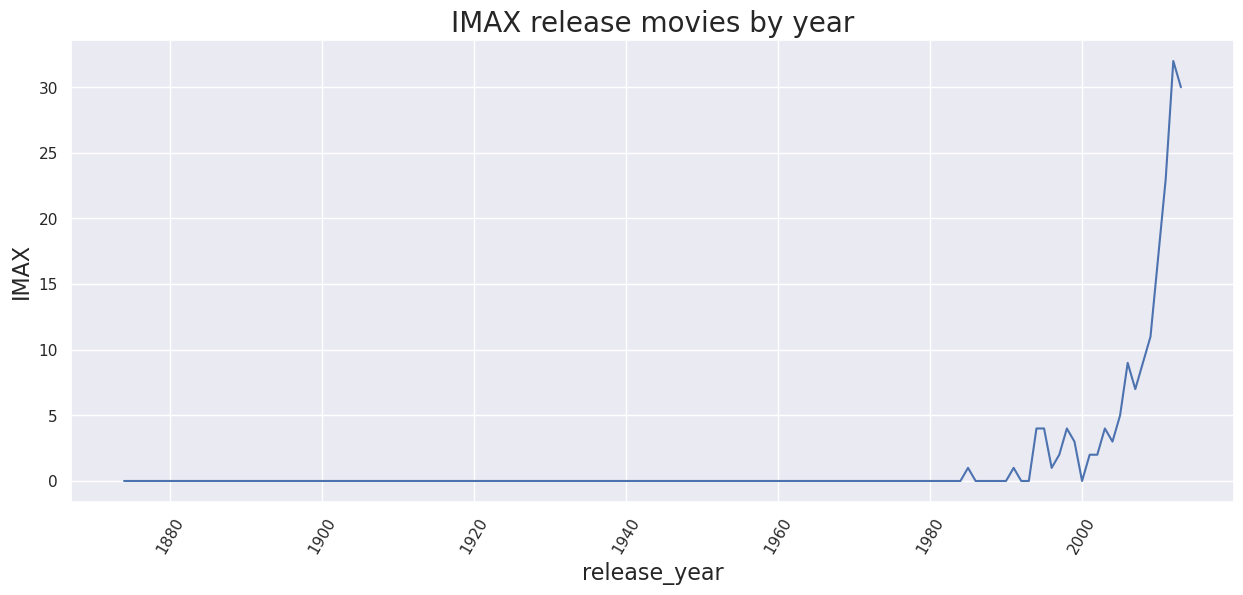

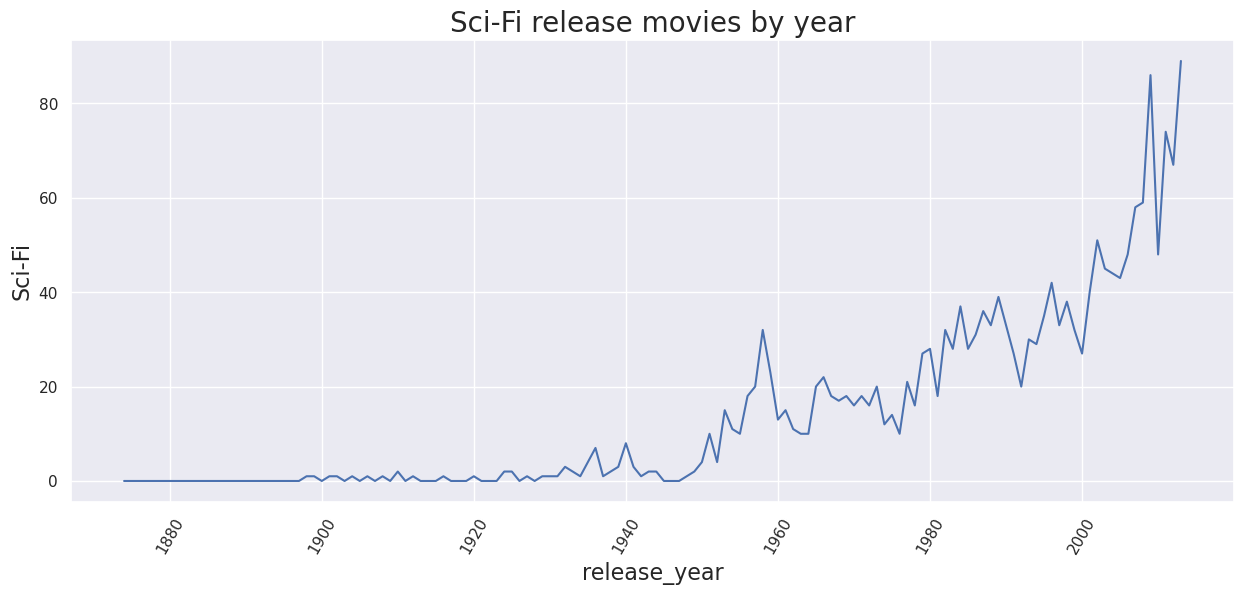

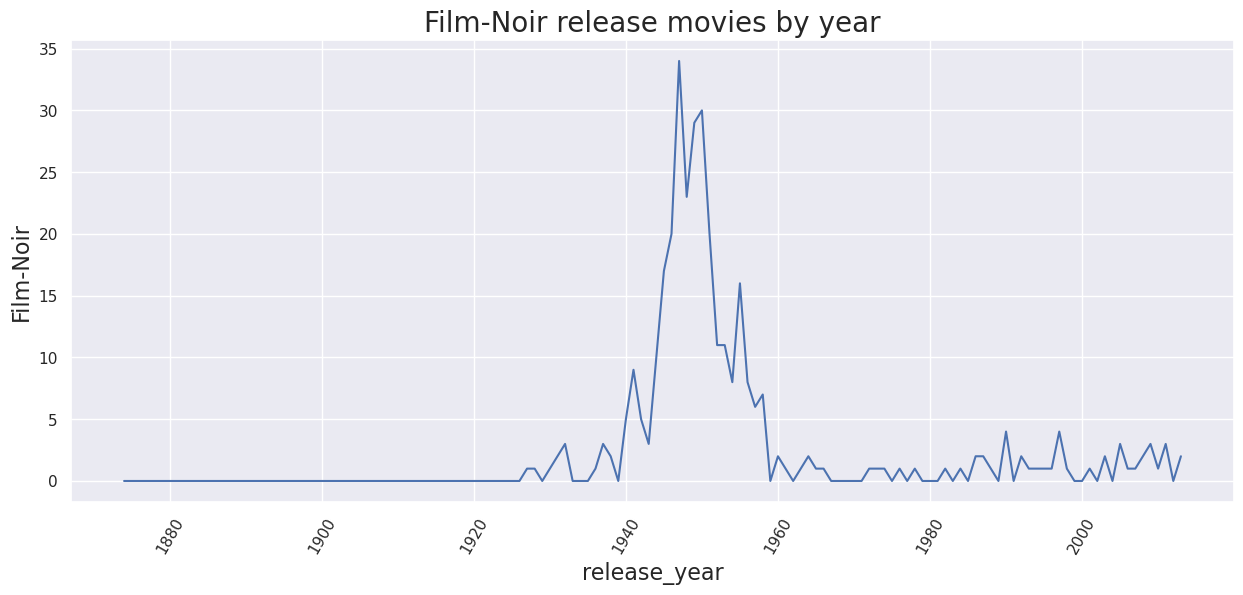

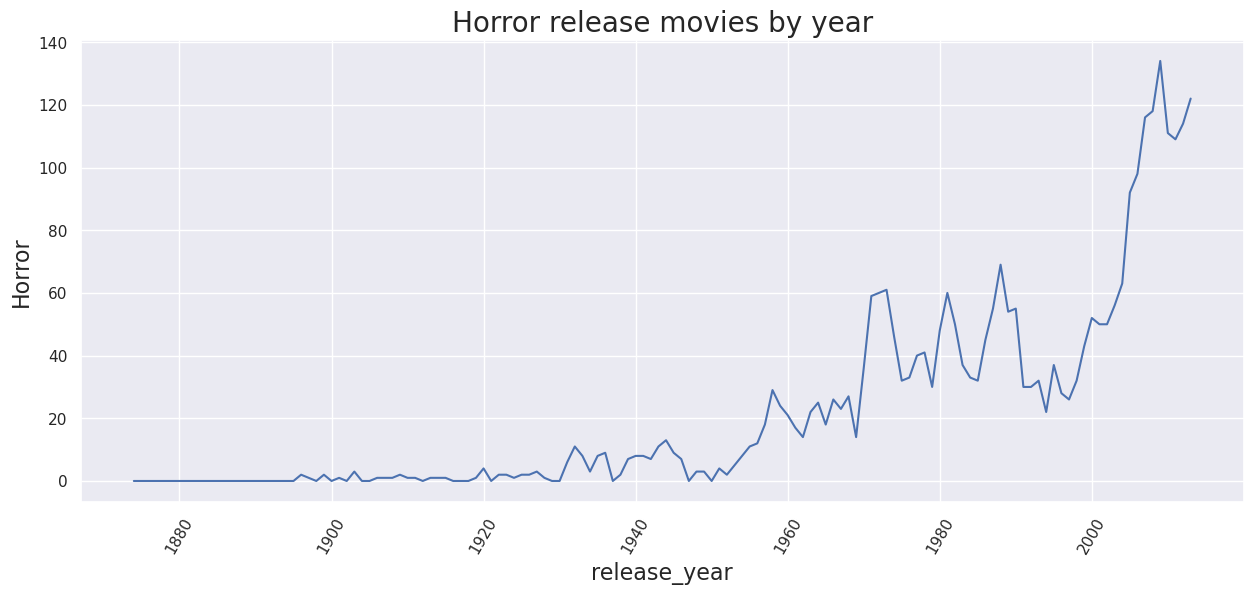

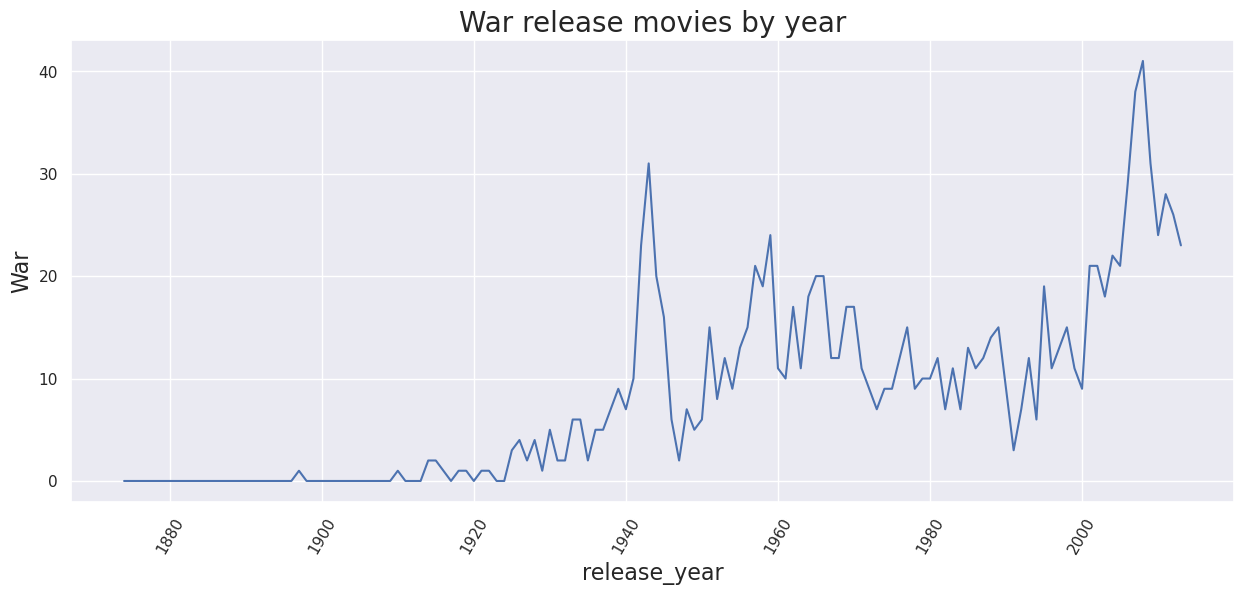

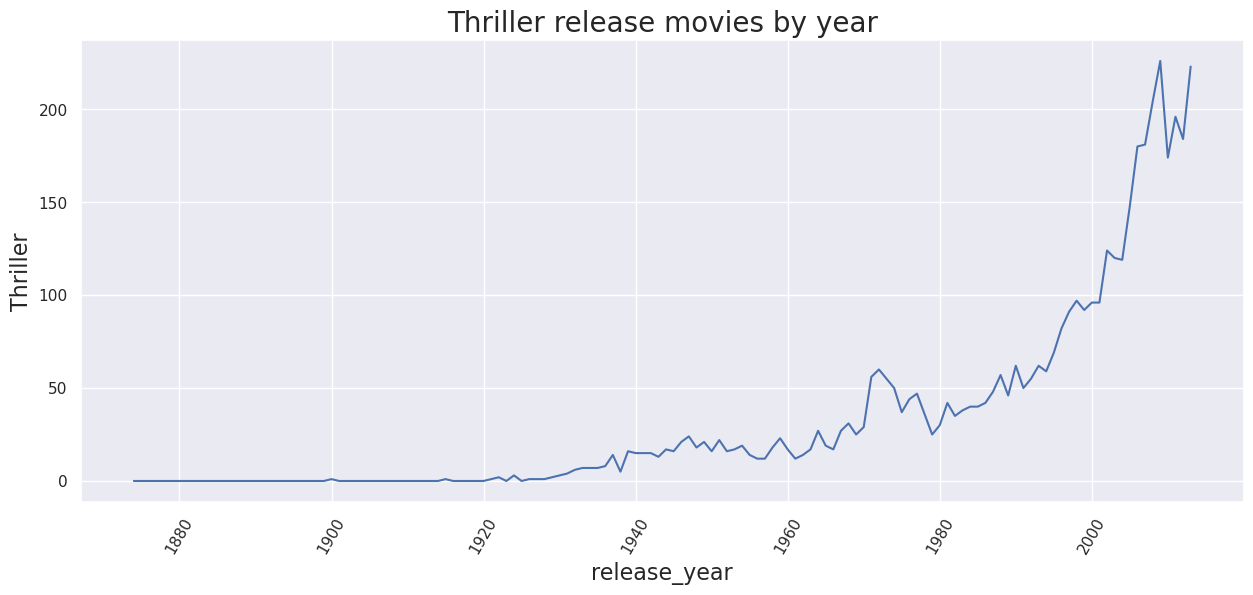

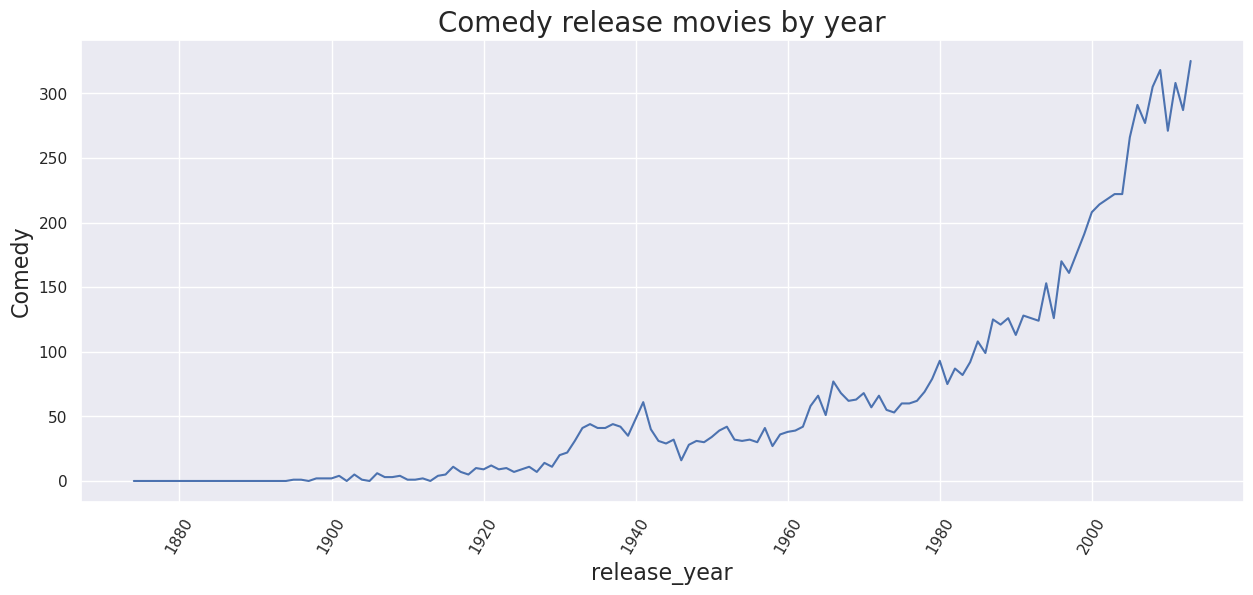

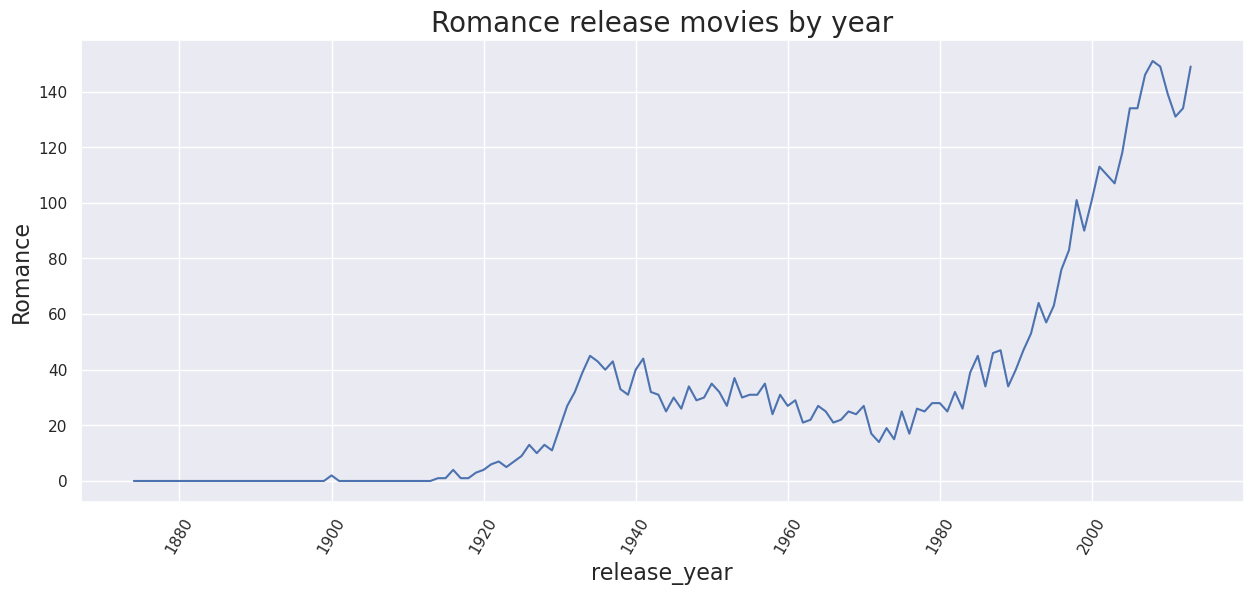

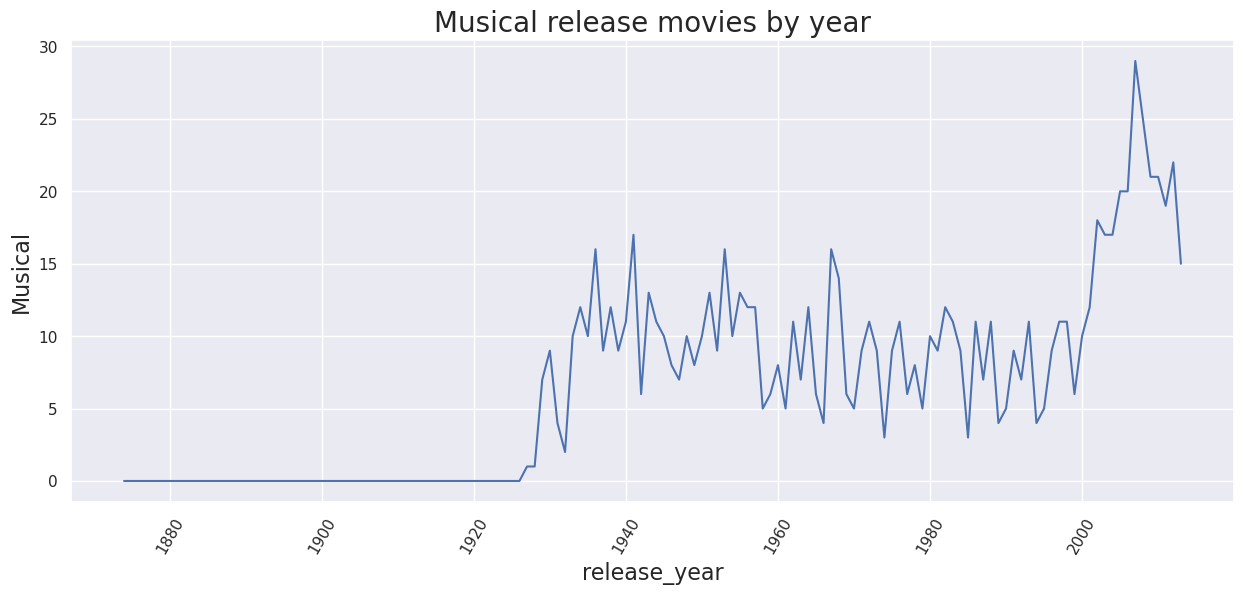

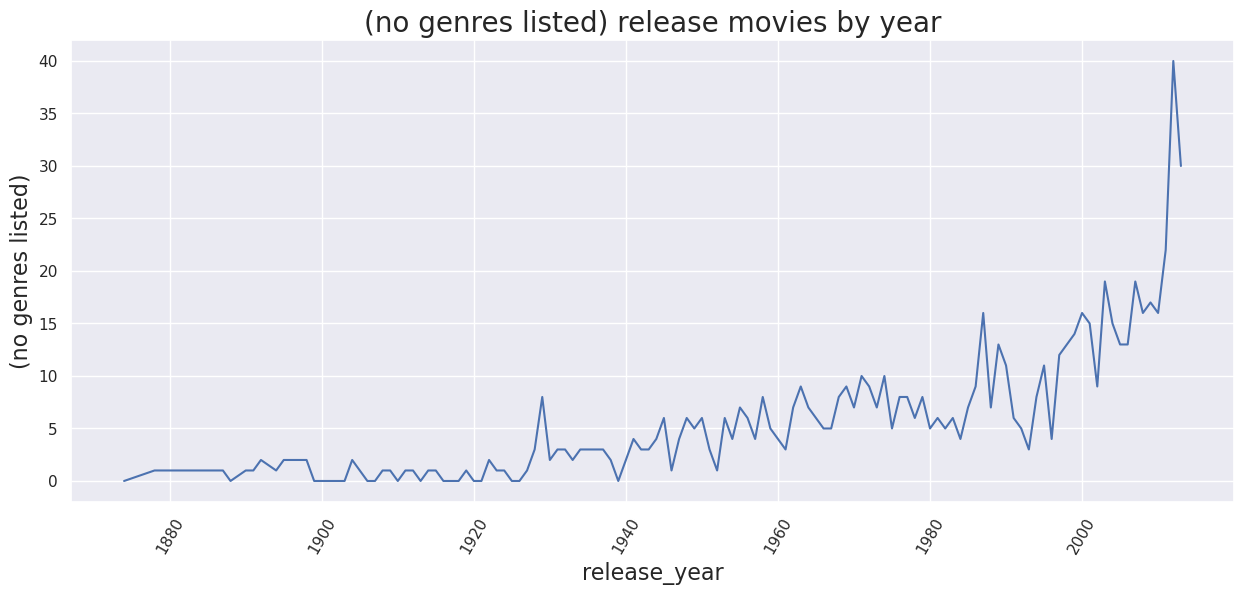

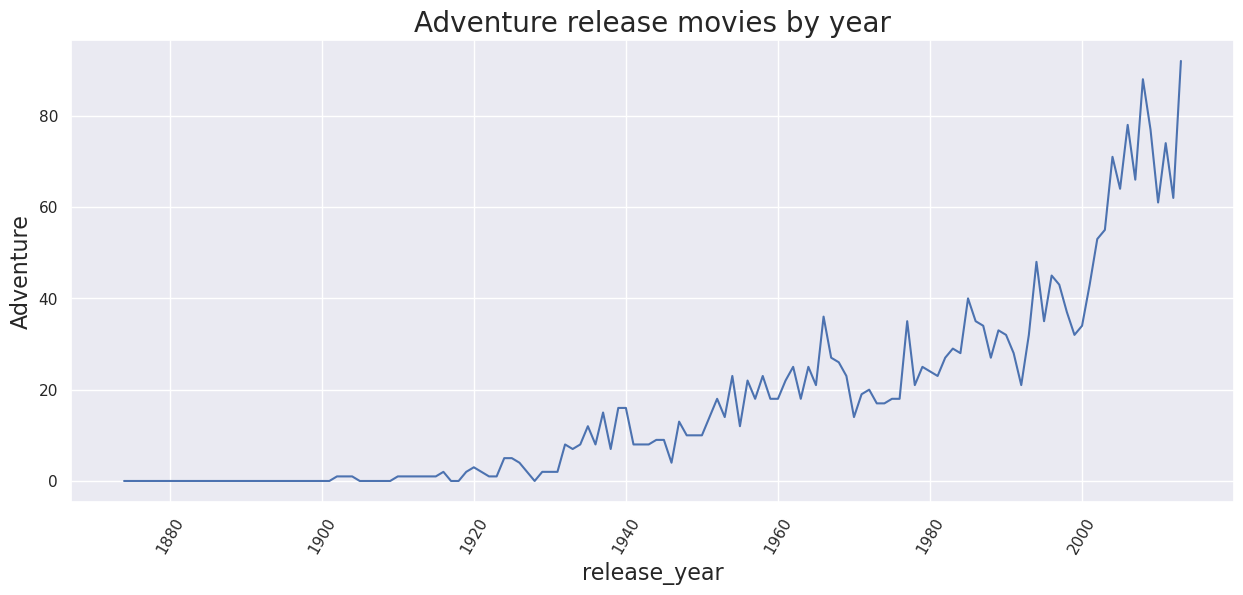

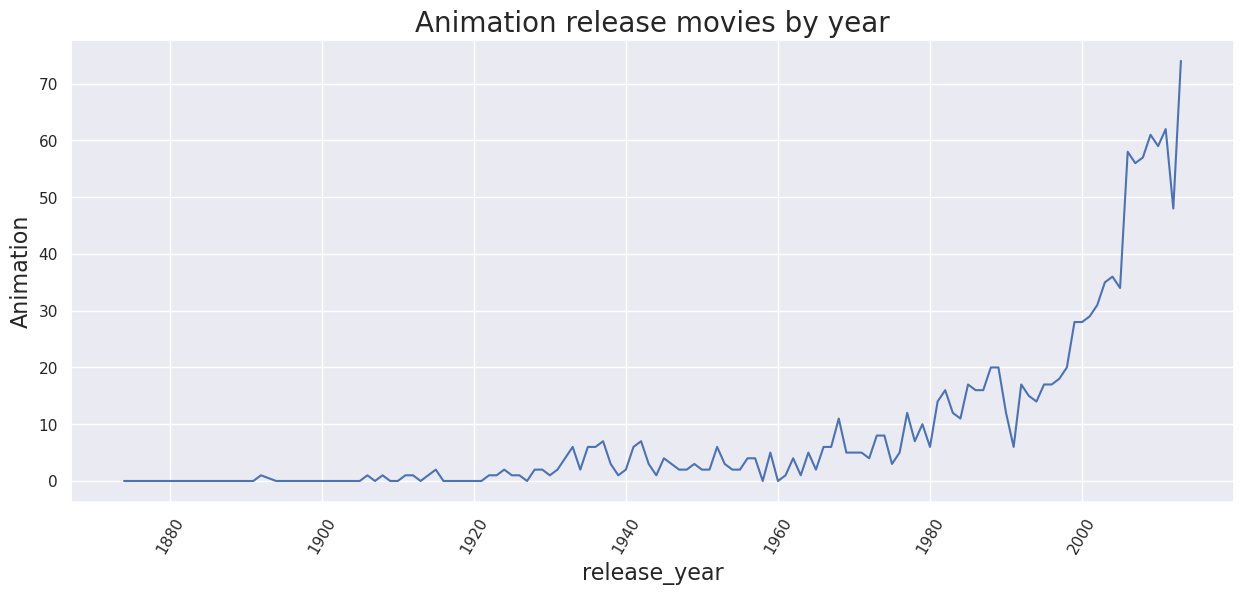

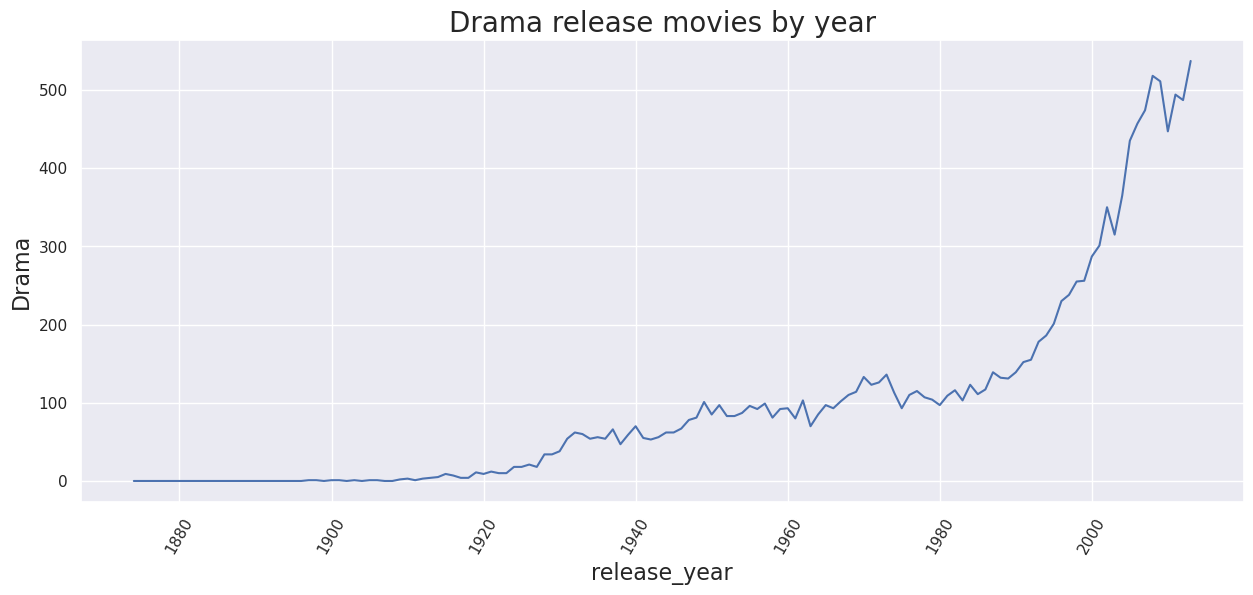

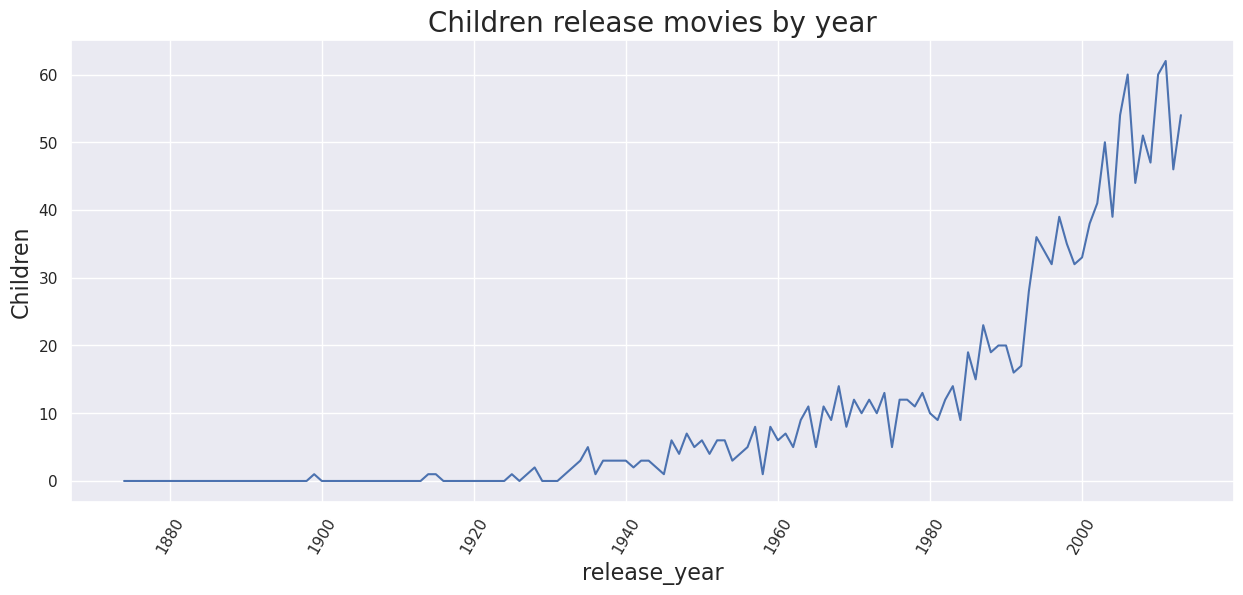

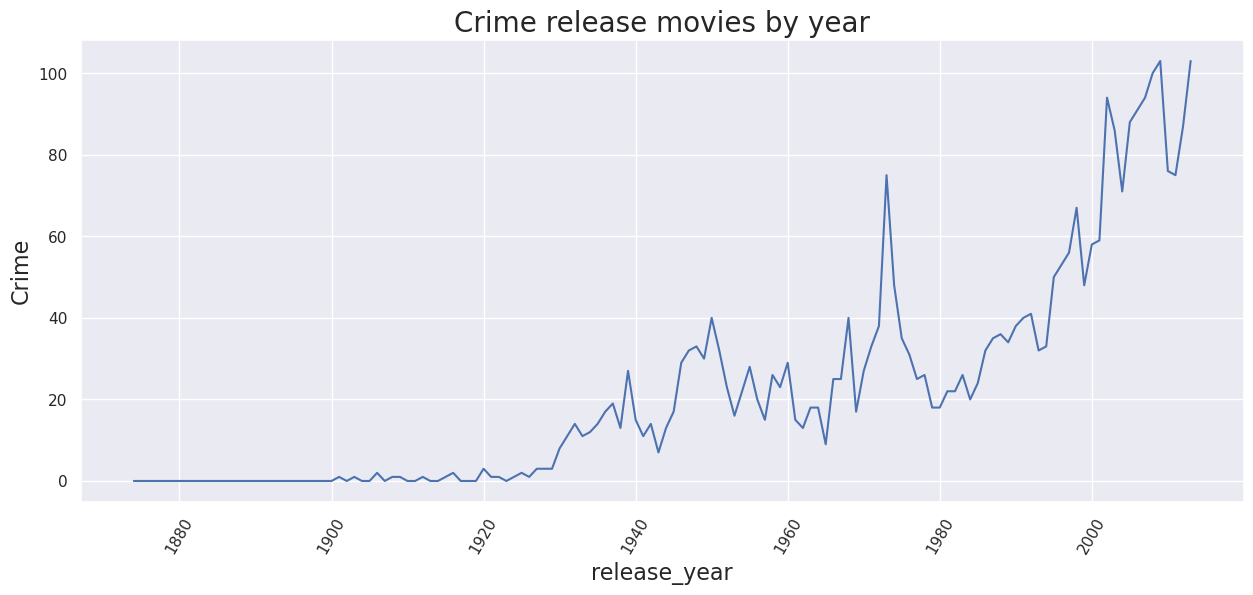

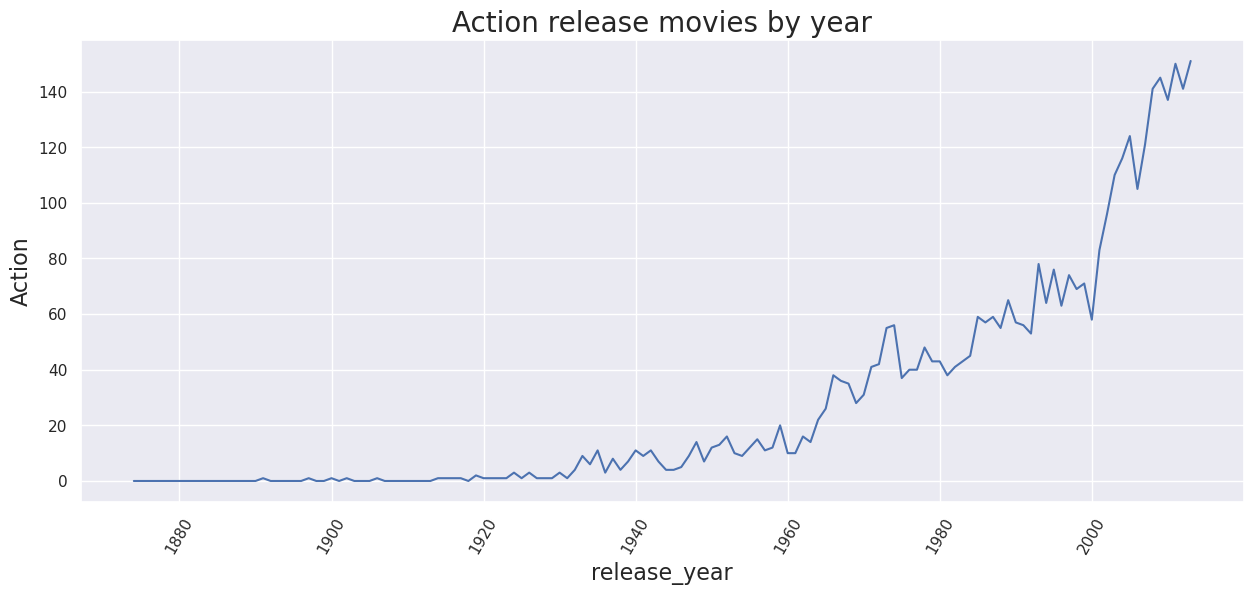

In [66]:
data = dt.list_column_to_dummy_columns(movies3, 'genres')

genres_columns = list(set(data.columns) - set(movies3.columns))

data = data[['release_year'] + genres_columns]

data = data[data['release_year'] <= 2013]


data = data[['release_year'] + genres_columns] \
    .groupby('release_year') \
    [genres_columns] \
    .sum() \
    .sort_values(by='release_year', ascending=True) \
    .reset_index()

[pl.lineplot(data, x='release_year', y=col, title=f'{col} release movies by year') for col in genres_columns]
None

In [67]:
interactions

rating           timestamp  user_id  movie_id  \
0          4.5 2015-07-27 21:07:28   100001       260   
1          4.5 2016-01-16 12:58:26   100016    111659   
2          2.0 2016-01-16 13:01:35   100016    112290   
3          5.0 2015-01-25 20:55:28   100016    114180   
4          4.5 2017-01-02 08:42:53   100016    117438   
...        ...                 ...      ...       ...   
210720     3.5 2013-09-09 15:28:53     9998    102903   
210721     5.0 2015-02-09 22:17:10     9998    112183   
210722     4.0 2012-08-01 17:48:28     9998      5418   
210723     2.5 2012-08-08 20:05:55     9998     58025   
210724     3.0 2013-03-05 22:24:45     9998     58103   

                                                     tags  year  
0       [adventure, classic, classic sci-fi, epic, joh...  2015  
1              [fairy tale, good vs evil, visual effects]  2016  
2                    [bad jokes, boring, horrible acting]  2016  
3            [amnesia, good acting, plot holes, survival]  2015  
4                              [beautiful, studio ghibli]  2017  
...                                                   ...   ...  
210720                               [pseudo-intelligent]  2013  
210721  [alter ego, edward norton, great performances,...  2015  
210722                  [assassin, espionage, matt damon]  2012  
210723  [concept, samuel l. jackson, silly, superhero,...  2012  
210724                                       [repetitive]  2013  

[210725 rows x 6 columns]

In [68]:
interactions = ut.datetime_to_seq(interactions, 'timestamp', 'rating_seq')
interactions

rating           timestamp  user_id  movie_id  \
0          4.5 2015-07-27 21:07:28   100001       260   
1          4.5 2016-01-16 12:58:26   100016    111659   
2          2.0 2016-01-16 13:01:35   100016    112290   
3          5.0 2015-01-25 20:55:28   100016    114180   
4          4.5 2017-01-02 08:42:53   100016    117438   
...        ...                 ...      ...       ...   
210720     3.5 2013-09-09 15:28:53     9998    102903   
210721     5.0 2015-02-09 22:17:10     9998    112183   
210722     4.0 2012-08-01 17:48:28     9998      5418   
210723     2.5 2012-08-08 20:05:55     9998     58025   
210724     3.0 2013-03-05 22:24:45     9998     58103   

                                                     tags  year  rating_seq  
0       [adventure, classic, classic sci-fi, epic, joh...  2015      119237  
1              [fairy tale, good vs evil, visual effects]  2016      132268  
2                    [bad jokes, boring, horrible acting]  2016      132270  
3            [amnesia, good acting, plot holes, survival]  2015      108996  
4                              [beautiful, studio ghibli]  2017      149346  
...                                                   ...   ...         ...  
210720                               [pseudo-intelligent]  2013       94823  
210721  [alter ego, edward norton, great performances,...  2015      109563  
210722                  [assassin, espionage, matt damon]  2012       82592  
210723  [concept, samuel l. jackson, silly, superhero,...  2012       82725  
210724                                       [repetitive]  2013       89069  

[210725 rows x 7 columns]

Cuantas interacciones se realizaron en un mismo momento en el tiempo?

In [69]:
df_tmp = interactions \
    .groupby(['timestamp', 'rating_seq']) \
    .size() \
    .reset_index(name='count') \
    .sort_values(['count'], ascending=False)

df_tmp[df_tmp['count'] > 20]

timestamp  rating_seq  count
154274 2017-03-29 03:31:35      154275    210
154273 2017-03-29 03:31:34      154274    161
154275 2017-03-29 03:31:36      154276     42
166490 2017-12-04 22:08:02      166491     27
157151 2017-05-21 02:40:28      157152     26
172666 2018-03-19 06:25:54      172667     23

In [70]:
movies3.to_json(f'{DATASETS_PATH}/movies.json')
interactions.to_json(f'{DATASETS_PATH}/interactions.json')

### References

* https://www.kaggle.com/code/amar09/eda-recommendation-model-on-movielens-100k/notebook
* https://jovian.ai/surendranjagadeesh/movielens-eda